# Grid World  & Deep Q learning

In [1]:
import torch
import numpy as np
import cv2
import random
import time
import gym
from Gridworld_Game import Gridworld
from IPython.display import clear_output
from matplotlib import pyplot as plt
import os

In [2]:
Grid_size = 4
game = Gridworld(Grid_size=Grid_size,mode='static')

In [3]:
game.actions_space

Discrete(4)

In [4]:
game.observation_space

Box([[[0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]]

 [[0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]]

 [[0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]]

 [[0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]]], [[[1 1 1 1]
  [1 1 1 1]
  [1 1 1 1]
  [1 1 1 1]]

 [[1 1 1 1]
  [1 1 1 1]
  [1 1 1 1]
  [1 1 1 1]]

 [[1 1 1 1]
  [1 1 1 1]
  [1 1 1 1]
  [1 1 1 1]]

 [[1 1 1 1]
  [1 1 1 1]
  [1 1 1 1]
  [1 1 1 1]]], (4, 4, 4), int32)

In [6]:
game.step(0)

(array([[[1, 0, 0, 0],
         [0, 0, 0, 0],
         [0, 0, 0, 0],
         [0, 0, 0, 0]],
 
        [[0, 0, 0, 0],
         [0, 1, 0, 0],
         [0, 0, 0, 0],
         [0, 0, 0, 0]],
 
        [[0, 0, 0, 0],
         [0, 0, 0, 0],
         [0, 0, 0, 0],
         [0, 0, 0, 0]],
 
        [[0, 0, 0, 0],
         [0, 0, 0, 1],
         [0, 0, 0, 0],
         [0, 0, 1, 0]]]),
 -1,
 False,
 {'items': {'Agent': 0, 'Hole': 1, 'Wall': 2, 'Goal': 3},
  'Grid_size': 4,
  'actions': ['Left', 'Right', 'Up', 'Down']})

In [7]:
action = game.actions_space.sample()

In [8]:
game.reset()
game.render(mode='human')
time.sleep(5)
game.close()

In [10]:
actions = {'left':0,'right':1,'up':2,'down':3}

In [11]:
game.step(actions['left'])

(array([[[0, 0, 0, 0],
         [0, 0, 0, 0],
         [0, 0, 0, 0],
         [0, 0, 0, 0]],
 
        [[1, 0, 0, 0],
         [0, 1, 0, 0],
         [0, 0, 0, 0],
         [0, 0, 0, 0]],
 
        [[0, 0, 0, 0],
         [0, 0, 0, 0],
         [0, 0, 0, 0],
         [0, 0, 0, 0]],
 
        [[0, 0, 0, 0],
         [0, 0, 0, 1],
         [0, 0, 0, 0],
         [0, 0, 1, 0]]]),
 -1,
 False,
 {'items': {'Agent': 0, 'Hole': 1, 'Wall': 2, 'Goal': 3},
  'Grid_size': 4,
  'actions': ['Left', 'Right', 'Up', 'Down']})

In [13]:
class Net(torch.nn.Module):
    def __init__(self, input_shape , output_shape):
        super(Net, self).__init__()
        self.linear1 = torch.nn.Linear(input_shape , 150)
        self.linear2 = torch.nn.Linear(150 ,100)
        self.linear3 = torch.nn.Linear(100 ,output_shape)
        self.activation = torch.nn.ReLU()
    def forward(self ,x):
        x = self.linear1(x)
        x = self.activation(x)
        x = self.linear2(x)
        x = self.activation(x)
        x = self.linear3(x)
        return x

In [14]:
def preprocess_state(state ,input_shape , add_noise = False):
    if add_noise == True:
        state = state.reshape(*input_shape)  + np.random.rand(*input_shape)/100.0     
    else:
        state = state.reshape(*input_shape)
    return state

In [15]:
def get_action(Q_val ,num_actions ,epsilon):
    if (random.random() < epsilon): 
        action = np.random.randint(0,num_actions)
    else:
        action = np.argmax(Q_val ,1)[0]
    return action

In [16]:
class target_maker:
    def __init__(self,terminal_rewards):
            self.terminal_rewards = terminal_rewards
            
    def __call__ (self,current_reward ,gamma , maxQ):
            if current_reward not in self.terminal_rewards: 
                Y = current_reward + (gamma * maxQ)
            else:
                Y = current_reward
            Y = torch.Tensor([Y]).detach() 
            return Y

In [17]:
def update(loss , optimizer):
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

In [18]:
input_shape = Grid_size**3
output_shape = len(actions)
Agent = Net(input_shape ,output_shape)

In [20]:
epochs = 3000
losses = [] 
gamma = 0.9
learning_rate = 0.001
optimizer = torch.optim.Adam(Agent.parameters(), lr=learning_rate)
loss_fn = torch.nn.MSELoss()
create_target = target_maker([-10,+10])
epsilon = 1.0

for i in range(epochs): 
    game = Gridworld(Grid_size=4,mode='static',frame_size=(800,800,3)) #C
    game.reset()
    state1 = game.state
    state1 = preprocess_state(state1 ,(1,input_shape) ,add_noise = True)
    state1 = torch.from_numpy(state1).float() 
    status = 1 
    while(status == 1): 
        qval = Agent(state1) 
        qval_ = qval.data.detach().numpy()
        action = get_action(qval_ , 4 ,epsilon)
        state2 ,reward ,done ,_ = game.step(action)
        state2 = preprocess_state(state2 ,(1,input_shape) ,add_noise = True)
        state2 = torch.from_numpy(state2).float() 

        with torch.no_grad():
            newQ = Agent(state2)
        maxQ = torch.max(newQ)
        game.render()
        Y = create_target(reward ,gamma ,maxQ)
        X = qval.squeeze()[action] 
        loss = loss_fn(X, Y) 
        print(i, loss.item())
        clear_output(wait=True)
        optimizer.zero_grad()
        loss.backward()
        losses.append(loss.item())
        optimizer.step()
        state1 = state2
        
        if done == True: 
            status = 0
            
    if epsilon > 0.1: 
        epsilon -= (1/epochs)

2999 0.01264728233218193


Text(0, 0.5, 'Loss')

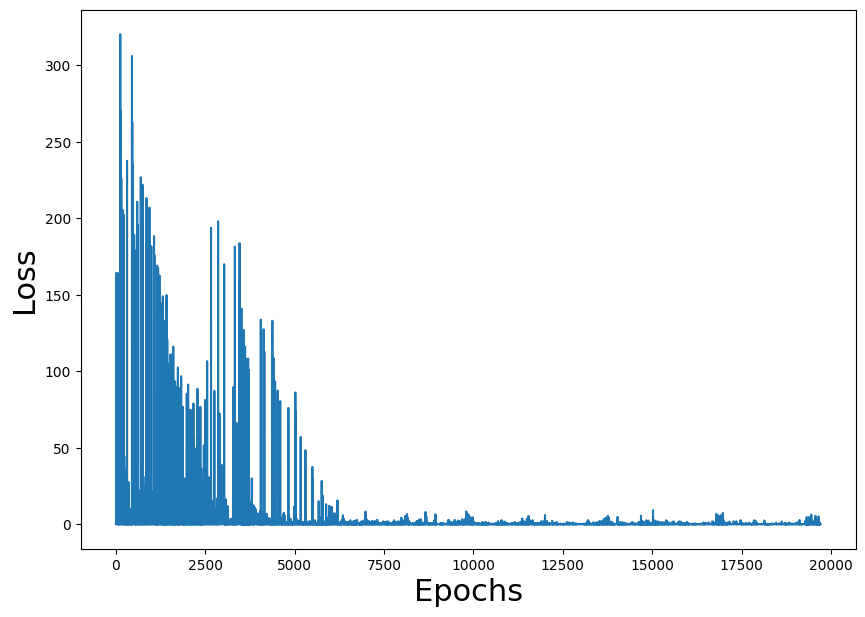

In [21]:
plt.figure(figsize=(10,7))
plt.plot(losses)
plt.xlabel("Epochs",fontsize=22)
plt.ylabel("Loss",fontsize=22)

In [23]:
episodes = 5
mov = 0
max_mov = 15
for i in range(episodes):
    game = Gridworld(Grid_size=Grid_size,mode='static')
    state1 = game.state 
    state1 = preprocess_state(state1,(1 ,input_shape) ,add_noise=True)
    state1 = torch.from_numpy(state1).float() 
    gate = 1
    while(gate == 1):
        mov += 1
        Q_val = Agent(state1)
        Q_val_numpy = Q_val.detach().numpy()
        action = action = np.argmax(Q_val_numpy ,1)[0]
        state2 , reward ,done ,_ = game.step(action)
        state2 = preprocess_state(state2,(1 ,input_shape) ,add_noise=True)
        state2 = torch.from_numpy(state2).float() 
        game.render()
        time.sleep(1)
        if done == True or mov == max_mov: 
            gate = 0
        state1 = state2
    game.close()

### <font color='red'>Train on batches</font> 


In [50]:
def get_batch(replay ,batch_size ,device = "cpu"):
    minibatch = random.sample(replay, batch_size)
    state1_batch = torch.cat([s1 for (s1,a,r,s2,d) in minibatch]).to(device)
    action_batch = torch.Tensor([a for (s1,a,r,s2,d) in minibatch]).long().to(device)
    reward_batch = torch.Tensor([r for (s1,a,r,s2,d) in minibatch]).to(device)
    state2_batch = torch.cat([s2 for (s1,a,r,s2,d) in minibatch]).to(device)
    done_batch = torch.Tensor([d for (s1,a,r,s2,d) in minibatch]).to(device)
    return state1_batch ,action_batch ,reward_batch ,state2_batch ,done_batch    

In [51]:
def batch_target(reward_batch ,gamma , maxQ ,done_batch): 
    Y = reward_batch + (gamma * maxQ * (1 - done_batch))
    return Y

In [52]:
def reward_metric(all_rewards_list ,last_n_rewards = 20):
    if len(all_rewards_list) >= last_n_rewards:
        mean_reward = np.mean(all_rewards_list[-last_n_rewards:])
    else:
        mean_reward = 0
    return mean_reward

In [19]:
from collections import deque
memory_size = 5000
batch_size = 200
replay = deque(maxlen=memory_size)
gamma = 0.9
learning_rate = 0.001
epochs = 10000
device="cuda"
losses = [] 
Agent = Net(input_shape ,output_shape).to(device)
optimizer = torch.optim.Adam(Agent.parameters(), lr=learning_rate)
loss_fn = torch.nn.MSELoss()
epsilon = 1.0

all_rewards_list = []
mean_rewards = []

for i in range(epochs):
    game = Gridworld(Grid_size=4,mode='random',frame_size=(800,800,3))
    game.reset()
    state1 = game.state
    state1 = preprocess_state(state1 ,(1,input_shape) ,add_noise = False)
    state1 = torch.from_numpy(state1).float().to(device)
    status = 1 
    mov = 0
    while(status == 1): 
        mov += 1
        qval = Agent(state1) 
        qval_ = qval.data.detach().cpu().numpy()

        action = get_action(qval_ , 4,epsilon)
        state2 ,reward ,done ,_ = game.step(action)

        state2 = preprocess_state(state2 ,(1,input_shape) ,add_noise = False)
        state2 = torch.from_numpy(state2).float().to(device)
        exp =  (state1, action, reward, state2, done)
        replay.append(exp) 
        game.render()
        if len(replay) > batch_size: 
            state1_batch ,action_batch ,reward_batch ,state2_batch ,done_batch = get_batch(replay ,batch_size ,device)
            Q1 = Agent(state1_batch) 
            with torch.no_grad():
                Q2 = Agent(state2_batch) 
            maxQ = torch.max(Q2 ,axis = 1)[0]
            Y = batch_target(reward_batch ,gamma ,maxQ ,done_batch)
            X = Q1.gather(dim=1,index=action_batch.unsqueeze(dim=1)).squeeze()
            loss = loss_fn(X, Y) 
            print(i ,loss.item())
            clear_output(wait=True)
            losses.append(loss.item())
            update(loss ,optimizer)
 
            all_rewards_list.append(reward)
            mean_reward = reward_metric(all_rewards_list , 100)
            mean_rewards.append(mean_reward)
            
        state1 = state2
        if done == True or mov > max_moves: 
            status = 0
            mov = 0
    if epsilon > 0.1: 
        epsilon -= (1/epochs)

NameError: name 'input_shape' is not defined

In [20]:
plt.figure(figsize=(10,7))
plt.plot(mean_rewards)
plt.xlabel("steps",fontsize=22)
plt.ylabel("rewards",fontsize=22)

NameError: name 'mean_rewards' is not defined

<Figure size 1000x700 with 0 Axes>

Text(0, 0.5, 'Loss')

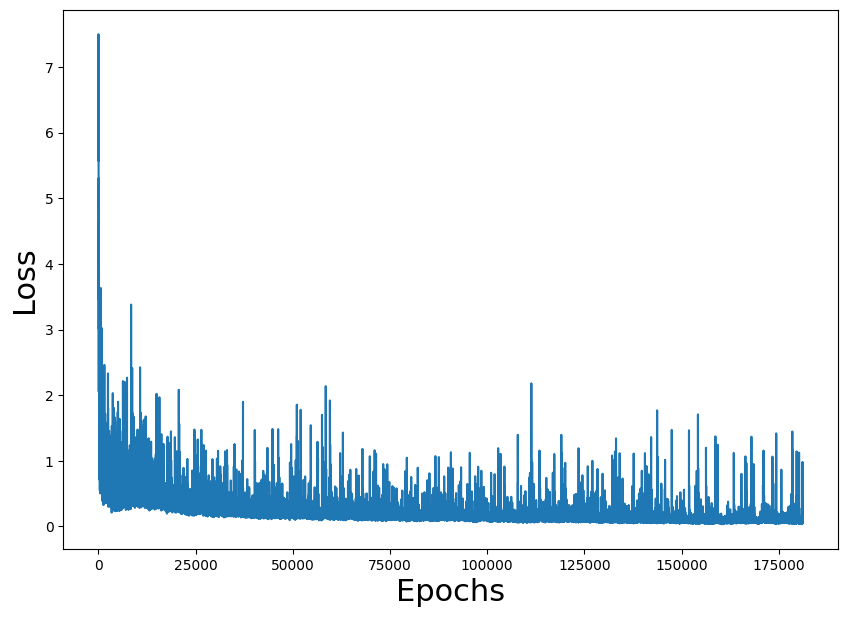

In [110]:
plt.figure(figsize=(10,7))
plt.plot(losses)
plt.xlabel("Epochs",fontsize=22)
plt.ylabel("Loss",fontsize=22)

In [47]:
episodes = 10
max_mov = 10
for i in range(episodes):
    game = Gridworld(Grid_size=Grid_size,mode='random')
    state1 = game.state 
    state1 = preprocess_state(state1,(1 ,input_shape) ,add_noise=True)
    state1 = torch.from_numpy(state1).float().to(device)
    gate = 1
    mov = 0
    while(gate == 1):
        mov += 1
        Q_val = Agent(state1)
        Q_val_numpy = Q_val.detach().cpu().numpy()
        action = action = np.argmax(Q_val_numpy ,1)[0]
        state2 , reward ,done ,_ = game.step(action)
        state2 = preprocess_state(state2,(1 ,input_shape) ,add_noise=True)
        state2 = torch.from_numpy(state2).float().to(device)
        game.render()
        time.sleep(0.1)
        if done == True or mov == max_mov: 
            gate = 0
        state1 = state2
    game.close()

### <font color='red'>Target network</font> 


In [19]:
from collections import deque
import copy

memory_size = 5000
batch_size = 200
replay = deque(maxlen=memory_size)
gamma = 0.9
learning_rate = 0.001
epochs = 10000
sync_freq = 500
k = 0
device="cuda"
losses = [] 
Agent_NN = Net(input_shape ,output_shape).to(device)
target_NN = copy.deepcopy(Agent_NN)
target_NN.load_state_dict(Agent_NN.state_dict()) 


optimizer = torch.optim.Adam(Agent_NN.parameters(), lr=learning_rate)
loss_fn = torch.nn.MSELoss()
epsilon = 1.0

all_rewards_list = []
mean_rewards = []

for i in range(epochs):
    game = Gridworld(Grid_size=4,mode='random',frame_size=(800,800,3))
    game.reset()
    state1 = game.state
    state1 = preprocess_state(state1 ,(1,input_shape) ,add_noise = True)
    state1 = torch.from_numpy(state1).float().to(device)
    status = 1 
    while(status == 1): 
        k = k + 1
        qval = Agent_NN(state1) 
        qval_ = qval.data.detach().cpu().numpy()

        action = get_action(qval_ , 4,epsilon)
        state2 ,reward ,done ,_ = game.step(action)

        state2 = preprocess_state(state2 ,(1,input_shape) ,add_noise = True)
        state2 = torch.from_numpy(state2).float().to(device)
        exp =  (state1, action, reward, state2, done)
        replay.append(exp) 
        game.render()
        if len(replay) > batch_size: 
            state1_batch ,action_batch ,reward_batch ,state2_batch ,done_batch = get_batch(replay ,batch_size ,device)
            Q1 = Agent_NN(state1_batch) 
            with torch.no_grad():
                Q2 = target_NN(state2_batch) 
            maxQ = torch.max(Q2 ,axis = 1)[0]
            Y = batch_target(reward_batch ,gamma ,maxQ ,done_batch)
            X = Q1.gather(dim=1,index=action_batch.unsqueeze(dim=1)).squeeze()
            loss = loss_fn(X, Y) 
            print(i ,loss.item())
            clear_output(wait=True)
            losses.append(loss.item())
            update(loss ,optimizer)
 
            all_rewards_list.append(reward)
            mean_reward = reward_metric(all_rewards_list , 100)
            mean_rewards.append(mean_reward)
            
        state1 = state2
        
        if k % sync_freq == 0: 
            target_NN.load_state_dict(Agent_NN.state_dict())
            
        if done == True: 
            status = 0
            
    if epsilon > 0.1: 
        epsilon -= (1/epochs)

NameError: name 'input_shape' is not defined

Text(0, 0.5, 'rewards')

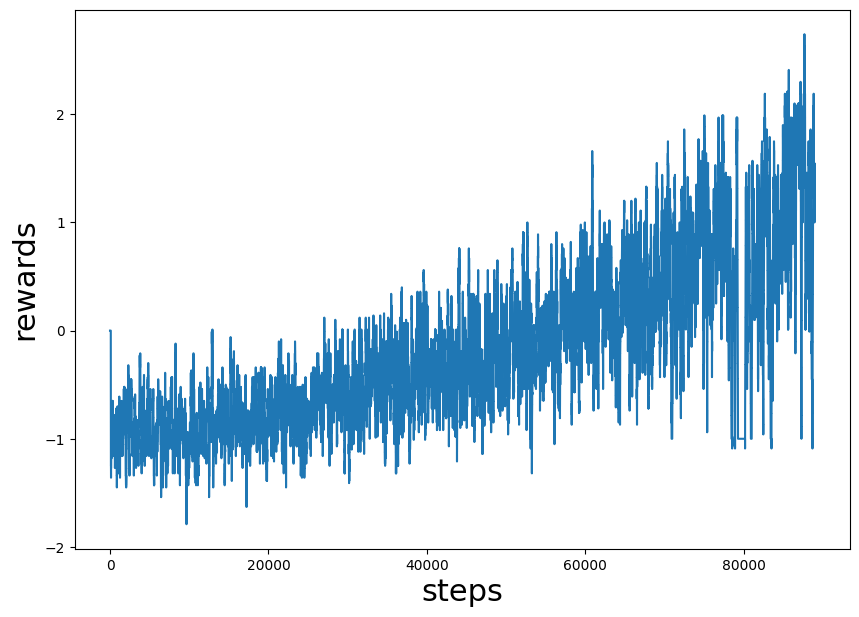

In [116]:
plt.figure(figsize=(10,7))
plt.plot(mean_rewards)
plt.xlabel("steps",fontsize=22)
plt.ylabel("rewards",fontsize=22)

Text(0, 0.5, 'Loss')

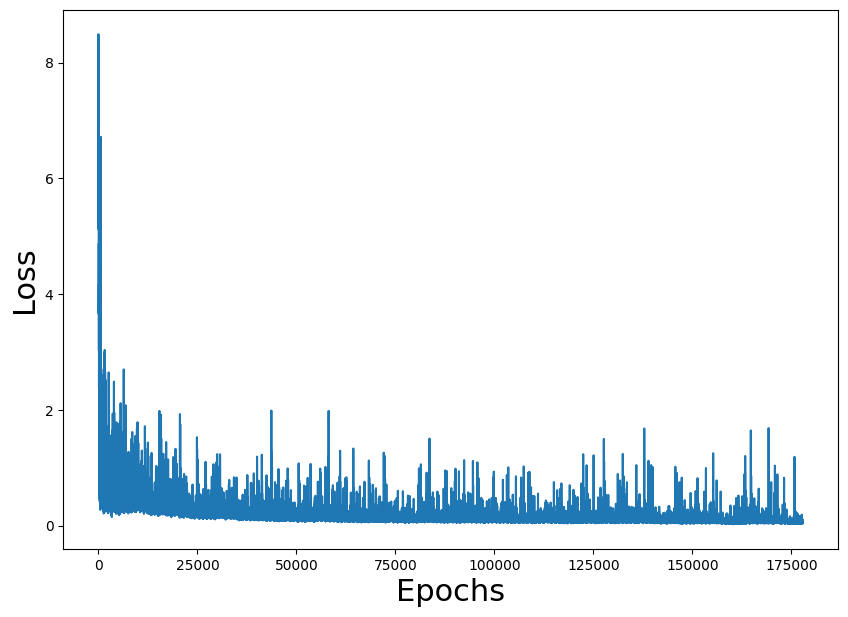

In [117]:
plt.figure(figsize=(10,7))
plt.plot(losses)
plt.xlabel("Epochs",fontsize=22)
plt.ylabel("Loss",fontsize=22)

In [20]:
while(os.getcwd().split('\\')[-1] != "RL"):
      os.chdir(os.path.dirname(os.getcwd()))

# MountainCar  & Deep Q learning

In [25]:
import gym
env = gym.make('MountainCar-v0')

In [26]:
print(env.observation_space)

Box([-1.2  -0.07], [0.6  0.07], (2,), float32)


In [27]:
env.observation_space.sample()

array([-0.36414555,  0.00713531], dtype=float32)

In [28]:
env.action_space

Discrete(3)

In [29]:
env.action_space.sample()

2

In [30]:
actions = {'left':0 , 'do_nothing':1 ,'right':2} 

In [31]:
env.reset()

array([-0.58210456,  0.        ], dtype=float32)

In [32]:
env.step(actions['right'])

(array([-0.580668  ,  0.00143654], dtype=float32), -1.0, False, {})

In [33]:
env.render(mode="human")

True

In [34]:
env.close()

In [35]:
input_shape = env.observation_space.sample().shape[0]
print("input shape:",input_shape)
output_shape = len(actions)
print("output shape:",output_shape)

input shape: 2
output shape: 3


In [36]:
class Net(torch.nn.Module):
    def __init__(self, input_shape , output_shape):
        super(Net, self).__init__()
        self.linear1 = torch.nn.Linear(input_shape , 20)
        self.linear2 = torch.nn.Linear(20 ,10)
        self.linear3 = torch.nn.Linear(10 ,output_shape)
        self.activation = torch.nn.ReLU()
    def forward(self ,x):
        x = self.linear1(x)
        x = self.activation(x)
        x = self.linear2(x)
        x = self.activation(x)
        x = self.linear3(x)
        return x

In [28]:
from collections import deque
import copy

memory_size = 10000
batch_size = 200
replay = deque(maxlen=memory_size)
gamma = 0.9
learning_rate = 0.001
epochs = 2000
sync_freq = 100
k = 0
device="cuda"
losses = [] 
Agent_NN = Net(input_shape ,output_shape).to(device)
target_NN = copy.deepcopy(Agent_NN)
target_NN.load_state_dict(Agent_NN.state_dict()) 


optimizer = torch.optim.Adam(Agent_NN.parameters(), lr=learning_rate)
loss_fn = torch.nn.MSELoss()
epsilon = 1.0

all_rewards_list = []
mean_rewards = []

for i in range(epochs):
    game = gym.make('MountainCar-v0')
    game.reset()
    state1 = game.state
    state1 = preprocess_state(state1 ,(1,input_shape) ,add_noise = True)
    state1 = torch.from_numpy(state1).float().to(device)
    status = 1 
    while(status == 1): 
        k = k + 1
        qval = Agent_NN(state1) 
        qval_ = qval.data.detach().cpu().numpy()

        action = get_action(qval_ , 3,epsilon)
        state2 ,reward ,done ,_ = game.step(action)
        if state2[0] >= 0.5:
            reward = 10
        state2 = preprocess_state(state2 ,(1,input_shape) ,add_noise = True)
        state2 = torch.from_numpy(state2).float().to(device)
        
        exp =  (state1, action, reward, state2, done)
        replay.append(exp) 
        game.render()
        if len(replay) > batch_size: 
            state1_batch ,action_batch ,reward_batch ,state2_batch ,done_batch = get_batch(replay ,batch_size ,device)
            Q1 = Agent_NN(state1_batch) 
            with torch.no_grad():
                Q2 = target_NN(state2_batch) 
            maxQ = torch.max(Q2 ,axis = 1)[0]
            Y = batch_target(reward_batch ,gamma ,maxQ ,done_batch)
            X = Q1.gather(dim=1,index=action_batch.unsqueeze(dim=1)).squeeze()
            loss = loss_fn(X, Y) 
            print(i ,loss.item())
            clear_output(wait=True)
            losses.append(loss.item())
            update(loss ,optimizer)
 

            
        state1 = state2
        
        if k % sync_freq == 0: 
            target_NN.load_state_dict(Agent_NN.state_dict())
            
        if done == True: 
            all_rewards_list.append(reward)
            mean_reward = reward_metric(all_rewards_list , 10)
            mean_rewards.append(mean_reward)
            status = 0
            game.close()
            
    if epsilon > 0.1: 
        epsilon -= (1/epochs)

KeyboardInterrupt: 

Text(0, 0.5, 'losses')

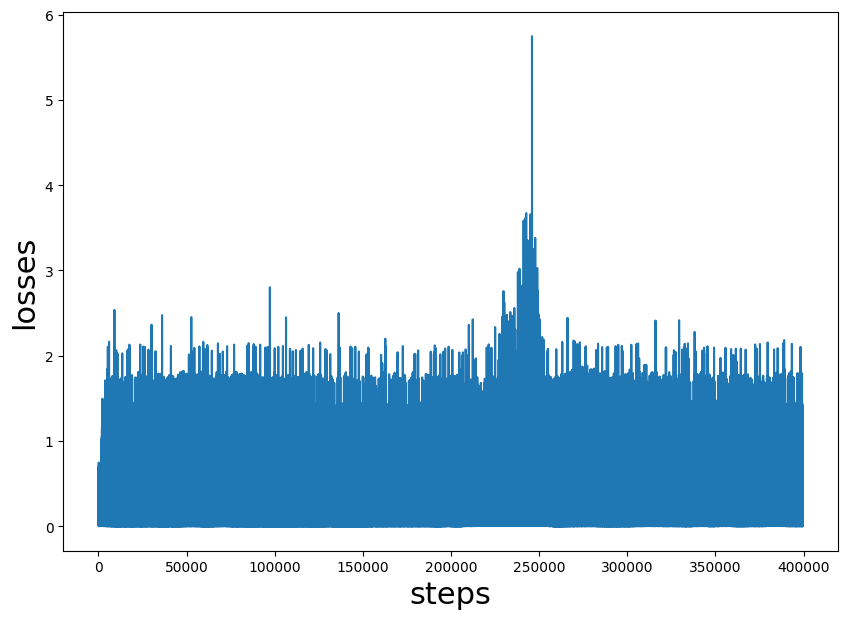

In [34]:
plt.figure(figsize=(10,7))
plt.plot(losses)
plt.xlabel("steps",fontsize=22)
plt.ylabel("losses",fontsize=22)

In [ ]:
episodes = 10
for i in range(episodes):
    game = gym.make('MountainCar-v0')
    game.reset()
    state1 = game.state 
    state1 = preprocess_state(state1,(1 ,input_shape) ,add_noise=True)
    state1 = torch.from_numpy(state1).float().to(device)
    gate = 1
    mov = 0
    while(gate == 1):
        mov += 1
        Q_val = Agent_NN(state1)
        Q_val_numpy = Q_val.detach().cpu().numpy()
        action = np.argmax(Q_val_numpy ,1)[0]
        state2 , reward ,done ,_ = game.step(action)
        state2 = preprocess_state(state2,(1 ,input_shape) ,add_noise=True)
        state2 = torch.from_numpy(state2).float().to(device)
        game.render()
        if done == True: 
            gate = 0
            game.close()
        state1 = state2
    game.close()

Exception ignored in: <function Viewer.__del__ at 0x0000020BA5947640>
Traceback (most recent call last):
  File "C:\Users\pc\anaconda3\envs\ML\lib\site-packages\gym\envs\classic_control\rendering.py", line 185, in __del__
    self.close()
  File "C:\Users\pc\anaconda3\envs\ML\lib\site-packages\gym\envs\classic_control\rendering.py", line 101, in close
    self.window.close()
  File "C:\Users\pc\anaconda3\envs\ML\lib\site-packages\pyglet\window\win32\__init__.py", line 319, in close
    super(Win32Window, self).close()
  File "C:\Users\pc\anaconda3\envs\ML\lib\site-packages\pyglet\window\__init__.py", line 838, in close
    app.windows.remove(self)
  File "C:\Users\pc\anaconda3\envs\ML\lib\_weakrefset.py", line 114, in remove
    self.data.remove(ref(item))
KeyError: <weakref at 0x0000020BB1229D50; to 'Win32Window' at 0x0000020BB12065C0>


### <font color='red'>DQN with Model-Based Exploration</font> 


In [19]:
from scipy import stats
from torch.distributions.multivariate_normal import MultivariateNormal

def get_action_from_multivariate_normal_distribution(previous_states ,next_states):
    cov = torch.cov(previous_states.T)
    mean = torch.mean(previous_states,dim=0)
    log_probs = MultivariateNormal(mean, cov).log_prob(next_states)
    probs = torch.exp(log_probs)
    return torch.argmin(probs).item()

ModuleNotFoundError: No module named 'scipy'

In [23]:
def Dynamics_input_preprocess(state1_batch ,action_batch):
    action_batch = torch.nn.functional.one_hot(action_batch , num_classes= len(actions))
    x = torch.cat((state1_batch, action_batch) ,dim=1)
    return x

In [168]:
actions = {'left':0 , 'do_nothing':1 ,'right':2} 

In [28]:
Dynamics_input_shape = env.observation_space.sample().shape[0] + len(actions)
Dynamics_output_shape =  env.observation_space.sample().shape[0]

In [70]:
device = "cuda"
Dynamics_NN = Net(Dynamics_input_shape ,Dynamics_output_shape).to(device)

In [82]:
from collections import deque
import copy

memory_size = 10000
batch_size = 100 #<--changed
replay = deque(maxlen=memory_size)
gamma = 0.99
Q_learning_rate = 0.001
Dynamics_learning_rate = 0.002
epochs = 1000
sync_freq = 100 
N_recent_states = 50
exploration_only_steps = 10000
device="cuda"
Q_losses = [] 
Dynamics_losses = []
mean_reward = 0
Agent_NN = Net(input_shape ,output_shape).to(device)
target_NN = copy.deepcopy(Agent_NN)
target_NN.load_state_dict(Agent_NN.state_dict()) 


Q_optimizer = torch.optim.Adam(Agent_NN.parameters(), lr=Q_learning_rate)
Dynamics_optimizer = torch.optim.Adam(Dynamics_NN.parameters(), lr=Dynamics_learning_rate)

Q_loss_fn = torch.nn.MSELoss() 
Dynamics_loss_fn = torch.nn.MSELoss()
epsilon = 1.

all_rewards_list = []
mean_rewards = []

for i in range(epochs):
    game = gym.make('MountainCar-v0') 
    state1 = game.reset()
    state1 = preprocess_state(state1 ,(1,input_shape) ,add_noise = True)
    state1 = torch.from_numpy(state1).float().to(device)
    status = 1 
    k = 0
    while(status == 1): 
        k = k + 1
        qval = Agent_NN(state1) 
        qval_ = qval.data.detach().cpu().numpy()
        
        if (len(replay) < exploration_only_steps or (random.random() < epsilon))  and (len(replay) > N_recent_states):
            with torch.no_grad():
                previous_states = torch.cat([s2 for (s1,a,r,s2,d) in list(replay)[-N_recent_states:]])
                all_possible_actions = torch.arange(len(actions)).to(device)
                Dynamics_inputs = Dynamics_input_preprocess(state1.repeat(len(actions),1),all_possible_actions)
                Dynamics_preds = Dynamics_NN(Dynamics_inputs)
                Dynamics_preds = Dynamics_preds
                action = get_action_from_multivariate_normal_distribution(previous_states ,Dynamics_preds)
                
        else:
            action = np.argmax(qval_ ,1)[0]

        state2 ,reward ,done ,_ = game.step(action)

            
        if state2[0] >= 0.5:
            reward = 10
            
        state2 = preprocess_state(state2 ,(1,input_shape) ,add_noise = True)
        state2 = torch.from_numpy(state2).float().to(device)
        exp =  (state1, action, reward, state2, done)
        replay.append(exp) 
        #game.render()
        if len(replay) > batch_size: 
            state1_batch ,action_batch ,reward_batch ,state2_batch ,done_batch = get_batch(replay ,batch_size ,device)
            Q1 = Agent_NN(state1_batch) 
            with torch.no_grad():
                Q2 = target_NN(state2_batch) 
            maxQ = torch.max(Q2 ,axis = 1)[0]
            Y = batch_target(reward_batch ,gamma ,maxQ ,done_batch)
            X = Q1.gather(dim=1,index=action_batch.unsqueeze(dim=1)).squeeze()
            Q_loss = Q_loss_fn(X, Y) 
            Q_losses.append(Q_loss.item())
            update(Q_loss ,Q_optimizer)

            
            Dynamics_inputs = Dynamics_input_preprocess(state1_batch.detach(),action_batch.detach())


            Dynamics_preds = Dynamics_NN(Dynamics_inputs.detach())
            Dynamics_targets = state2_batch
            Dynamics_loss = Dynamics_loss_fn(Dynamics_preds ,Dynamics_targets)
            Dynamics_losses.append(Dynamics_loss.item())
            update(Dynamics_loss ,Dynamics_optimizer)          
            print(i ,"Q_loss:",Q_loss.item()," \n Dynamics_loss:" ,Dynamics_loss.item() ,"\n mean reward:",mean_reward)
            clear_output(wait=True)

        state1 = state2
        
        if k % sync_freq == 0:
            target_NN.load_state_dict(Agent_NN.state_dict())
            
        if done == True:
            all_rewards_list.append(reward)
            mean_reward = reward_metric(all_rewards_list , 10)
            mean_rewards.append(mean_reward)
            status = 0
            game.close()
    if epsilon >  0.01: 
        epsilon -= (1/epochs)        

999 Q_loss: 3.4537370204925537  
 Dynamics_loss: 2.2899435862200335e-05 
 mean reward: 7.8


Text(0, 0.5, 'rewards')

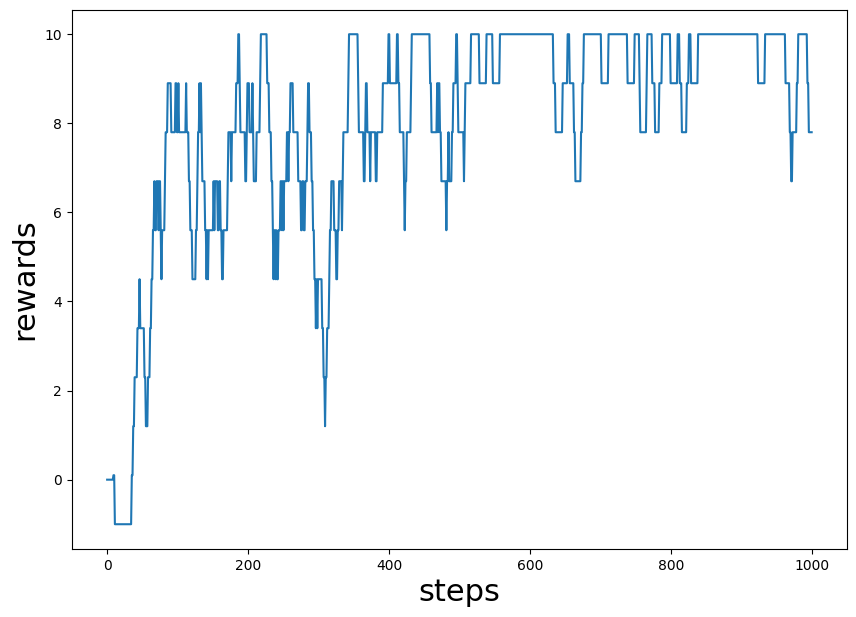

In [83]:
plt.figure(figsize=(10,7))
plt.plot(mean_rewards)
plt.xlabel("steps",fontsize=22)
plt.ylabel("rewards",fontsize=22)

Text(0, 0.5, 'losses')

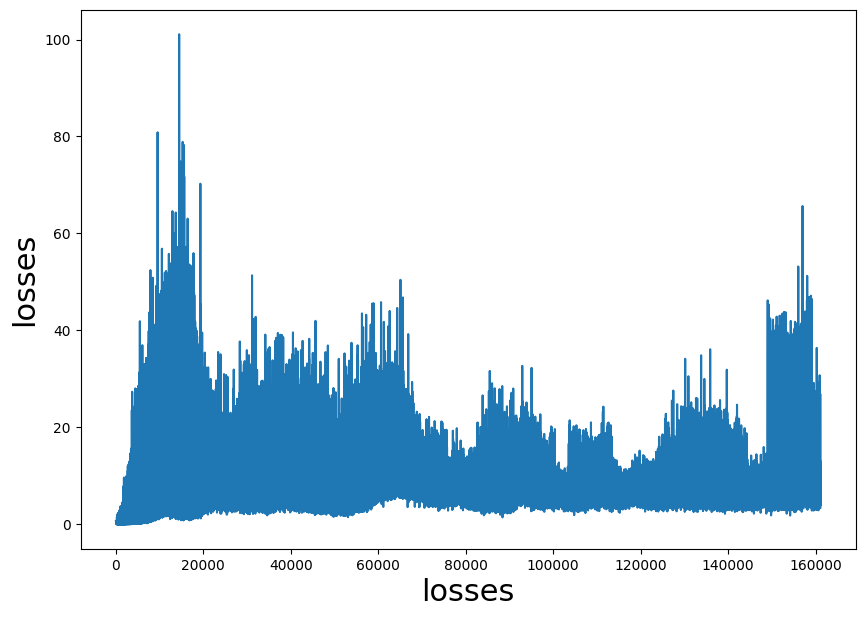

In [84]:
plt.figure(figsize=(10,7))
plt.plot(Q_losses)
plt.xlabel("losses",fontsize=22)
plt.ylabel("losses",fontsize=22)

In [ ]:
episodes = 10
for i in range(episodes):
    game = gym.make('MountainCar-v0')
    state1 = game.reset()
    state1 = preprocess_state(state1,(1 ,input_shape) ,add_noise=True)
    
    
    state1 = torch.from_numpy(state1).float().to(device)
    gate = 1
    while(gate == 1):
        Q_val = Agent_NN(state1)
        Q_val_numpy = Q_val.detach().cpu().numpy()
        action = np.argmax(Q_val_numpy ,1)[0]
        state2 , reward ,done ,_ = game.step(action)
        
        state2 = preprocess_state(state2,(1 ,input_shape) ,add_noise=True)
        state2 = torch.from_numpy(state2).float().to(device)
        game.render()
        time.sleep(0.01)
        if done == True: 
            gate = 0
            game.close()
        state1 = state2

### <font color='red'>ICM</font> 


In [21]:
class filter_Net(torch.nn.Module):
    def __init__(self, input_shape , output_shape):
        super(filter_Net, self).__init__()
        self.linear1 = torch.nn.Linear(input_shape , 32)
        self.linear2 = torch.nn.Linear(32 ,32)
        self.linear3 = torch.nn.Linear(32 ,output_shape)
        self.activation = torch.nn.ReLU()
        
    def forward(self ,x):
        x = torch.nn.functional.normalize(x)
        x = self.linear1(x)
        x = self.activation(x)
        x = self.linear2(x)
        x = self.activation(x)
        x = self.linear3(x)
        x = torch.nn.Tanh()(x)
        return x

In [33]:
device = "cuda"

In [34]:
input_filter_shape = env.observation_space.sample().shape[0] 
output_filter_shape = 3

filter_NN = filter_Net(input_filter_shape ,output_filter_shape).to(device)

In [35]:
filter_NN

filter_Net(
  (linear1): Linear(in_features=2, out_features=32, bias=True)
  (linear2): Linear(in_features=32, out_features=32, bias=True)
  (linear3): Linear(in_features=32, out_features=3, bias=True)
  (activation): ReLU()
)

In [20]:
class inverse_Net(torch.nn.Module):
    def __init__(self, input_shape , output_shape):
        super(inverse_Net, self).__init__()
        self.linear1 = torch.nn.Linear(input_shape , 32)
        self.linear2 = torch.nn.Linear(32 ,32)
        self.linear3 = torch.nn.Linear(32 ,output_shape)
        self.activation = torch.nn.ReLU()

        
    def forward(self ,x):
        
        x = self.linear1(x)
        x = self.activation(x)
        x = self.linear2(x)
        x = self.activation(x)
        x = self.linear3(x)
        x = torch.nn.functional.softmax(x ,dim=1)
        return x

In [37]:
input_inverse_shape = output_filter_shape * 2
output_inverse_shape = len(actions)
inverse_NN = inverse_Net(input_inverse_shape ,output_inverse_shape).to(device)

In [38]:
inverse_NN

inverse_Net(
  (linear1): Linear(in_features=6, out_features=32, bias=True)
  (linear2): Linear(in_features=32, out_features=32, bias=True)
  (linear3): Linear(in_features=32, out_features=3, bias=True)
  (activation): ReLU()
)

In [21]:
def inverse_input_preprocess(filtered_state1_batch ,filtered_state2_batch):
    x = torch.cat((filtered_state1_batch, filtered_state2_batch) ,dim=1)
    return x

In [22]:
def inverse_target_preprocess(action_batch):
    action_batch = torch.nn.functional.one_hot(action_batch ,num_classes = len(actions))
    return action_batch.float()

In [23]:
class forward_Net(torch.nn.Module):
    def __init__(self, input_shape , output_shape):
        super(forward_Net, self).__init__()
        self.linear1 = torch.nn.Linear(input_shape , 32)
        self.linear2 = torch.nn.Linear(32 ,32)
        self.linear3 = torch.nn.Linear(32 ,output_shape)
        self.activation = torch.nn.ReLU()
        
    def forward(self ,x):
        x = self.linear1(x)
        x = self.activation(x)
        x = self.linear2(x)
        x = self.activation(x)
        x = self.linear3(x)
        x = torch.nn.Tanh()(x)
        return x

In [44]:
def forward_input_preprocess(filtered_state1_batch ,action_batch):
    action_batch = torch.nn.functional.one_hot(action_batch ,num_classes = len(actions))
    x = torch.cat([filtered_state1_batch, action_batch] ,dim=1)
    return x

In [54]:
actions

{'left': 0, 'do_nothing': 1, 'right': 2}

In [55]:
input_forward_shape = output_filter_shape + len(actions)
output_forward_shape = output_filter_shape
forward_NN = forward_Net(input_forward_shape ,output_forward_shape).to(device)

In [56]:
output_forward_shape

3

In [57]:
forward_NN

forward_Net(
  (linear1): Linear(in_features=6, out_features=32, bias=True)
  (linear2): Linear(in_features=32, out_features=32, bias=True)
  (linear3): Linear(in_features=32, out_features=3, bias=True)
  (activation): ReLU()
)

In [48]:
class Q_Net(torch.nn.Module):
    def __init__(self, input_shape , output_shape):
        super(Q_Net, self).__init__()
        self.linear1 = torch.nn.Linear(input_shape , 128)
        self.linear2 = torch.nn.Linear(128 ,128)
        self.linear3 = torch.nn.Linear(128 ,output_shape)
        self.activation = torch.nn.ReLU()
    def forward(self ,x):
        x = self.linear1(x)
        x = self.activation(x)
        x = self.linear2(x)
        x = self.activation(x)
        x = self.linear3(x)
        return x

In [49]:
import copy
input_forward_shape = env.observation_space.sample().shape[0]
output_forward_shape = len(actions)
Agent_Q_NN = Q_Net(input_forward_shape ,output_forward_shape).to(device)
target_Q_NN = copy.deepcopy(Agent_Q_NN)
target_Q_NN.load_state_dict(Agent_Q_NN.state_dict()) 

<All keys matched successfully>

In [51]:
from collections import deque

memory_size = 100000
batch_size = 200 
replay = deque(maxlen=memory_size)
gamma = 0.99
learning_rate = 0.001
epochs = 500
sync_freq = 100 
mean_reward = 0
k = 0
β = 0.1
λ = 0.2
device="cuda"
Q_losses = [] 
inverse_losses = []
forward_losses = []

all_params = list(Agent_Q_NN.parameters()) + list(filter_NN.parameters()) + list(forward_NN.parameters()) + list(inverse_NN.parameters()) #new
optimizer = torch.optim.Adam(all_params, lr=learning_rate)


inverse_loss = torch.nn.CrossEntropyLoss(reduction='none') 
forward_loss = torch.nn.MSELoss(reduction='none') 
Q_loss = torch.nn.MSELoss() 
epsilon = 0.2
all_rewards_list = []
mean_rewards = []

for i in range(epochs):
    game = gym.make('MountainCar-v0')
    game.reset()
    state1 = game.reset()
    state1 = preprocess_state(state1 ,(1,input_shape) ,add_noise = False)
    state1 = torch.from_numpy(state1).float().to(device)
    status = 1 
    while(status == 1): 
        k = k + 1
        qval = Agent_Q_NN(state1) 
        qval_ = qval.data.detach().cpu().numpy()
        action = get_action(qval_ , 3,epsilon)
        
        state2 ,reward ,done ,_ = game.step(action)
        
        if state2[0] >= 0.5:
            reward = 10 

        state2 = preprocess_state(state2 ,(1,input_shape) ,add_noise = False)
        state2 = torch.from_numpy(state2).float().to(device)
        exp =  (state1, action, reward, state2, done)
        replay.append(exp) 
        game.render()
        if len(replay) > batch_size: 
            state1_batch ,action_batch ,reward_batch ,state2_batch ,done_batch = get_batch(replay ,batch_size ,device)
            
            filtered_state1_batch = filter_NN(state1_batch.detach())
            filtered_state2_batch = filter_NN(state2_batch.detach())
            forward_NN_input = forward_input_preprocess(filtered_state1_batch,action_batch).detach()

            filtered_state2_batch_pred = forward_NN(forward_NN_input)

            forward_pred_err = forward_loss(filtered_state2_batch_pred ,filtered_state2_batch.detach()).sum(dim=1).unsqueeze(dim=1) #new
            forward_losses.append(forward_pred_err.mean().item())
            print("forward loss:",forward_pred_err.mean().item())
            new_reward_batch =  forward_pred_err.detach().squeeze() + reward_batch

            inverse_NN_input = inverse_input_preprocess(filtered_state1_batch ,filtered_state2_batch)
            pred_action_batch = inverse_NN(inverse_NN_input)
            inverse_pred_err = inverse_loss(pred_action_batch ,action_batch.detach()).unsqueeze(dim=1) #new
            inverse_losses.append(inverse_pred_err.mean().item())
            print("inverse loss:",inverse_pred_err.mean().item())

            Q1 = Agent_Q_NN(state1_batch.detach()) 
            
            with torch.no_grad():
                Q2 = target_Q_NN(state2_batch) 
            maxQ = torch.max(Q2 ,axis = 1)[0]

            Y = batch_target(new_reward_batch.detach() ,gamma ,maxQ ,done_batch)
            X = Q1.gather(dim=1,index=action_batch.unsqueeze(dim=1)).squeeze()
            Q1_pred_err = Q_loss(X ,Y) 
            
            loss = (1 - β) * forward_pred_err + β * inverse_pred_err  
            loss = loss.sum() / loss.flatten().shape[0] 
            loss = λ * Q1_pred_err + loss
            update(loss ,optimizer)
            print(i ,"Q loss:",Q1_pred_err.item())
            
            Q_losses.append(Q1_pred_err.item())
            print("mean_reward:",mean_reward)
            clear_output(wait=True)
            
        state1 = state2
        
        if k % sync_freq == 0: 
            target_Q_NN.load_state_dict(Agent_Q_NN.state_dict())
            
        if done == True: 
            all_rewards_list.append(reward)
            mean_reward = reward_metric(all_rewards_list , 10)
            mean_rewards.append(mean_reward)
            print("mean_reward:",mean_reward)
            status = 0
            game.close()
            
    if epsilon >  0.01: 
        epsilon -= (1/epochs)


mean_reward: 10.0


Text(0, 0.5, 'Q_losses')

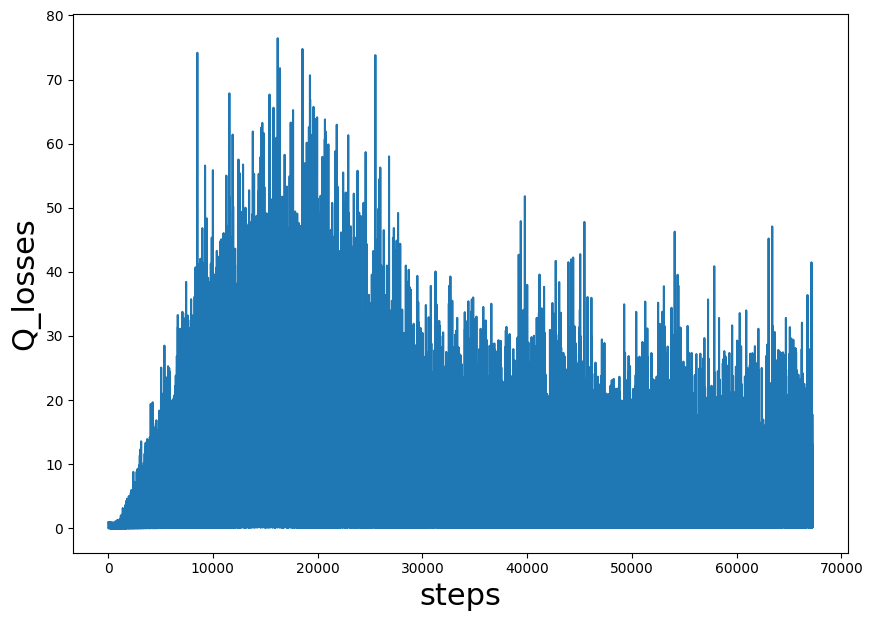

In [52]:
plt.figure(figsize=(10,7))
plt.plot(Q_losses)
plt.xlabel("steps",fontsize=22)
plt.ylabel("Q_losses",fontsize=22)

Text(0, 0.5, 'inverse_losses')

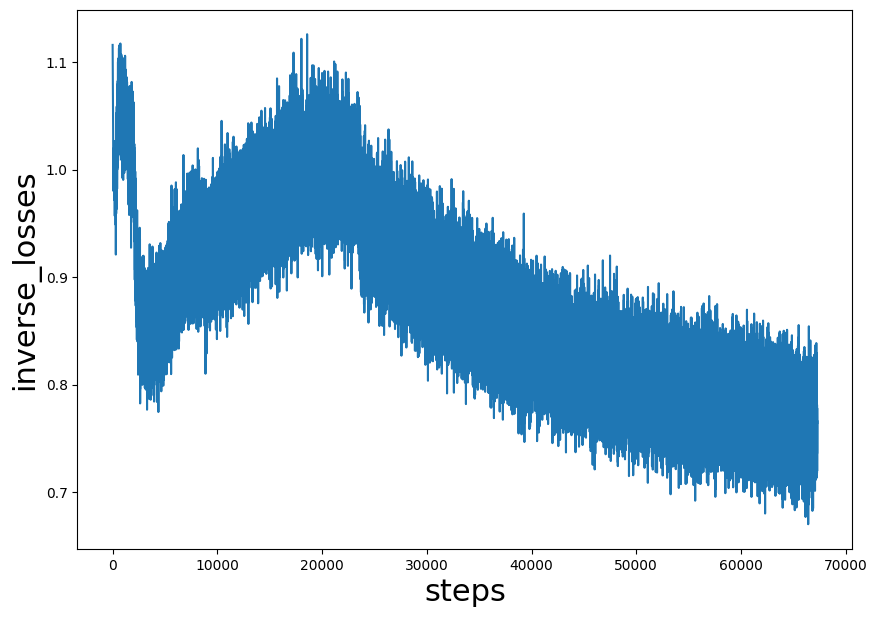

In [55]:
plt.figure(figsize=(10,7))
plt.plot(inverse_losses)
plt.xlabel("steps",fontsize=22)
plt.ylabel("inverse_losses",fontsize=22)

Text(0, 0.5, 'forward_losses')

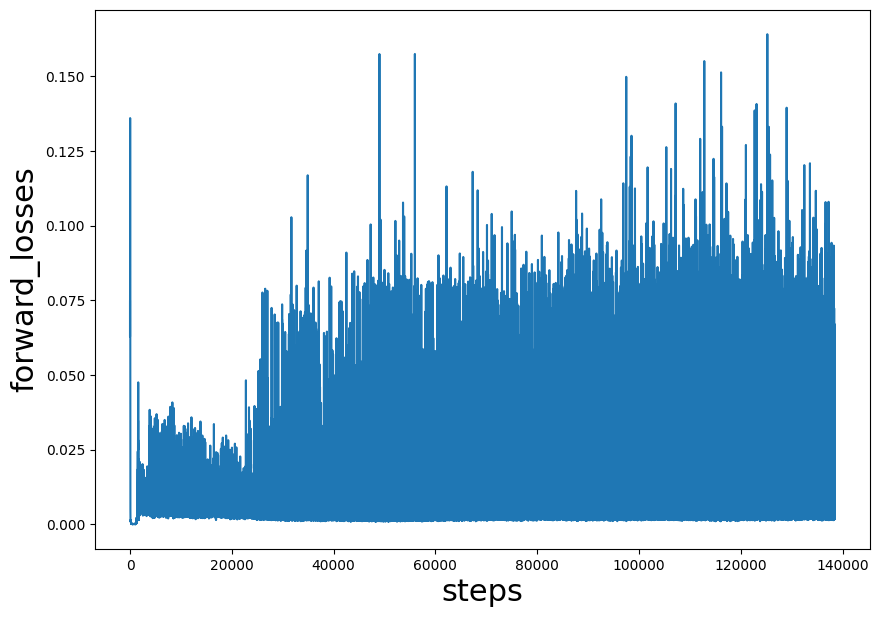

In [60]:
plt.figure(figsize=(10,7))
plt.plot(forward_losses)
plt.xlabel("steps",fontsize=22)
plt.ylabel("forward_losses",fontsize=22)

Text(0, 0.5, 'mean_rewards')

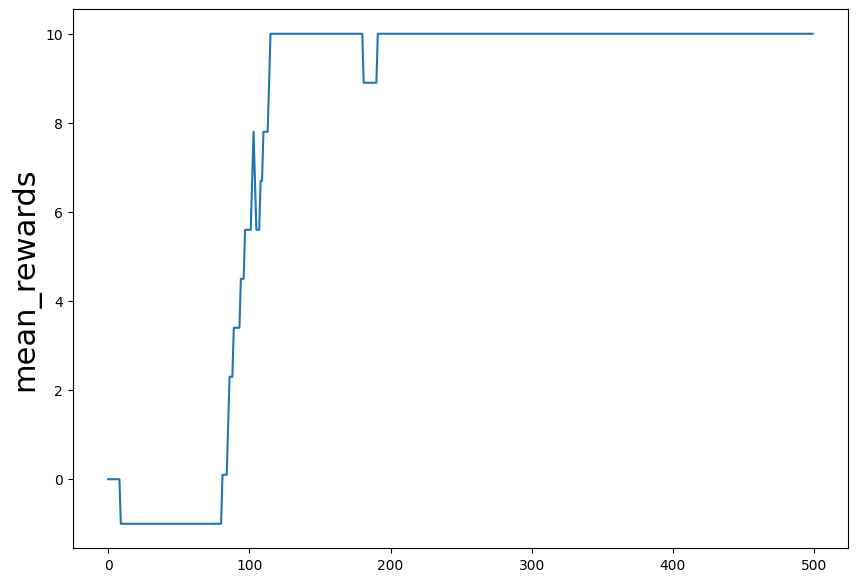

In [54]:
plt.figure(figsize=(10,7))
plt.plot(mean_rewards)
plt.ylabel("mean_rewards",fontsize=22)

In [63]:
episodes = 10
for i in range(episodes):
    game = gym.make('MountainCar-v0')
    state1 = game.reset()
    state1 = preprocess_state(state1,(1 ,input_shape) ,add_noise=False)
    
    
    state1 = torch.from_numpy(state1).float().to(device)
    gate = 1
    while(gate == 1):
        Q_val = Agent_Q_NN(state1)
        Q_val_numpy = Q_val.detach().cpu().numpy()
        action = np.argmax(Q_val_numpy ,1)[0]
        state2 , reward ,done ,_ = game.step(action)
        
        state2 = preprocess_state(state2,(1 ,input_shape) ,add_noise=False)
        state2 = torch.from_numpy(state2).float().to(device)
        game.render()
        time.sleep(0.01)
        if done == True: 
            gate = 0
            game.close()
        state1 = state2

NameError: name 'Agent_Q_NN' is not defined

### <font color='red'>RND</font> 


In [32]:
class P_Net(torch.nn.Module):
    def __init__(self, input_shape , output_shape):
        super(P_Net, self).__init__()
        self.linear1 = torch.nn.Linear(input_shape , 32)
        self.linear2 = torch.nn.Linear(32 ,32)
        self.linear3 = torch.nn.Linear(32 ,10)
        self.linear4 = torch.nn.Linear(10 ,output_shape)
        self.activation = torch.nn.ReLU()
        
    def forward(self ,x):
        x = self.linear1(x)
        x = self.activation(x)
        x = self.linear2(x)
        x = self.activation(x)
        x = self.linear3(x)
        x = self.activation(x)
        x = self.linear4(x)
        return x

In [33]:
device = "cuda"
input_P_shape = env.observation_space.sample().shape[0] 
output_P_shape = 3

P_NN = P_Net(input_P_shape ,output_P_shape).to(device)

In [34]:
class T_Net(torch.nn.Module):
    def __init__(self, input_shape , output_shape):
        super(T_Net, self).__init__()
        self.linear1 = torch.nn.Linear(input_shape , 32)
        self.linear2 = torch.nn.Linear(32 ,32)
        self.linear3 = torch.nn.Linear(32 ,output_shape)
        self.activation = torch.nn.ReLU()
        
    def forward(self ,x):
        x = self.linear1(x)
        x = self.activation(x)
        x = self.linear2(x)
        x = self.activation(x)
        x = self.linear3(x)
        return x

In [35]:
input_T_shape = env.observation_space.sample().shape[0] 
output_T_shape = output_P_shape
T_NN = T_Net(input_T_shape ,output_T_shape).to(device)

In [36]:
class Net(torch.nn.Module):
    def __init__(self, input_shape , output_shape):
        super(Net, self).__init__()
        self.linear1 = torch.nn.Linear(input_shape , 32)
        self.linear2 = torch.nn.Linear(32 ,32)
        self.linear3 = torch.nn.Linear(32 ,output_shape)
        self.activation = torch.nn.ReLU()
    def forward(self ,x):
        x = self.linear1(x)
        x = self.activation(x)
        x = self.linear2(x)
        x = self.activation(x)
        x = self.linear3(x)
        return x

In [52]:
def get_batch_for_RND(replay ,batch_size ,device = "cpu"):
    idxs = [i for i in range(len(replay))][batch_size:]
    idx = random.choice(idxs)
    _,_,_,_,_,f = replay[idx]
    
    if f < batch_size:
        if (len(replay) - idx) > (batch_size - f):
            minibatch = list(replay)[idx - f : idx + (batch_size - f)]
            
        else: 
            minibatch = list(replay)[idx - batch_size : idx]
    else:
        minibatch = list(replay)[idx - batch_size : idx] 
        
    state1_batch = torch.cat([s1 for (s1,a,r,s2,d,_) in minibatch]).to(device)
    action_batch = torch.Tensor([a for (s1,a,r,s2,d,_) in minibatch]).long().to(device)
    reward_batch = torch.Tensor([r for (s1,a,r,s2,d,_) in minibatch]).to(device)
    state2_batch = torch.cat([s2 for (s1,a,r,s2,d,_) in minibatch]).to(device)
    done_batch = torch.Tensor([d for (s1,a,r,s2,d,_) in minibatch]).to(device)
    
    mean = torch.mean(state1_batch ,dim=0)
    std =  torch.std(state1_batch ,dim=0)
    return state1_batch ,action_batch ,reward_batch ,state2_batch ,done_batch , mean ,std  

In [53]:
from collections import deque
import copy
input_shape = 2
output_shape = len(actions)
memory_size = 100000
batch_size = 64
replay = deque(maxlen=memory_size)
gamma = 0.99
P_learning_rate = 0.0001
Q_learning_rate = 0.001
epochs = 500
sync_freq = 100
k = 0
mean_reward = 0
device="cuda"
Q_losses = [] 
P_losses = []
Agent_NN = Net(input_shape ,output_shape).to(device)
target_NN = copy.deepcopy(Agent_NN)
target_NN.load_state_dict(Agent_NN.state_dict()) 

P_optimizer = torch.optim.Adam(P_NN.parameters(), lr=P_learning_rate)
Q_optimizer = torch.optim.Adam(Agent_NN.parameters(), lr=Q_learning_rate)

P_loss_fn = torch.nn.MSELoss(reduction="none")
Q_loss_fn = torch.nn.MSELoss()

epsilon = 0.2

all_rewards_list = []
mean_rewards = []
for i in range(epochs):
    game = gym.make('MountainCar-v0')
    state1 = game.reset()
    state1 = preprocess_state(state1 ,(1,input_shape) ,add_noise = False)
    state1 = torch.from_numpy(state1).float().to(device)
    status = 1 
    f = 0
    while(status == 1): 
        k = k + 1
        f = f + 1
        qval = Agent_NN(state1) 
        qval_ = qval.data.detach().cpu().numpy()        
        action = get_action(qval_ , 3, epsilon)    
        state2 ,reward ,done ,_ = game.step(action)
        if state2[0] >= 0.5:
            reward = 10
        state2 = preprocess_state(state2 ,(1,input_shape) ,add_noise = False)
        state2 = torch.from_numpy(state2).float().to(device)       
        exp =  (state1, action, reward, state2, done ,f)
        replay.append(exp)
        game.render()
        if len(replay) > batch_size: 
            state1_batch ,action_batch ,reward_batch ,state2_batch ,done_batch ,mean ,std= get_batch_for_RND(replay ,batch_size ,device)
            normalized_state2_batch = torch.clip((state2_batch.detach() - mean) / std ,min=-5,max=+5)
            predicted_next_state_representation_batch = P_NN(normalized_state2_batch)
            target_next_state_representation_batch = T_NN(normalized_state2_batch)
            P_loss_batch = P_loss_fn(predicted_next_state_representation_batch ,target_next_state_representation_batch.detach()).sum(dim=1)
            update(P_loss_batch.mean() ,P_optimizer)
            P_losses.append(P_loss_batch.mean().item())
            print("P_losses:",P_loss_batch.mean().item())
            new_rewards_batch = (P_loss_batch.detach() / torch.std(P_loss_batch.detach(),dim=0)) + reward_batch
            Q1 = Agent_NN(state1_batch.detach()) 
            with torch.no_grad():
                Q2 = target_NN(state2_batch) 
            maxQ = torch.max(Q2 ,axis = 1)[0]
            Y = batch_target(new_rewards_batch ,gamma ,maxQ ,done_batch)
            X = Q1.gather(dim=1,index=action_batch.unsqueeze(dim=1)).squeeze()
            Q_loss = Q_loss_fn(X, Y.detach()) 
            print(i ,Q_loss.item())
            clear_output(wait=True)
            Q_losses.append(Q_loss.item())
            update(Q_loss ,Q_optimizer)
            print("mean_reward:",mean_reward)

             
        state1 = state2
        
        if k % sync_freq == 0: 
            target_NN.load_state_dict(Agent_NN.state_dict())
            
        if done == True: 
            all_rewards_list.append(reward)
            mean_reward = reward_metric(all_rewards_list , 10)
            mean_rewards.append(mean_reward)
            status = 0
            game.close()
            
    if epsilon > 0.01: 
        epsilon -= (1/epochs)

mean_reward: 10.0


Text(0, 0.5, 'P_losses')

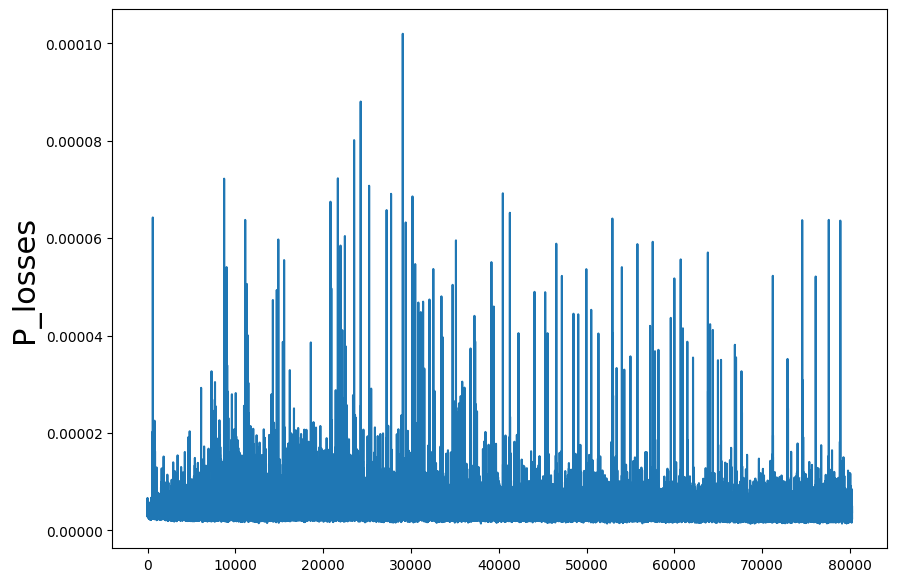

In [57]:
plt.figure(figsize=(10,7))
plt.plot(P_losses)
plt.ylabel("P_losses",fontsize=22)

Text(0, 0.5, 'Q_losses')

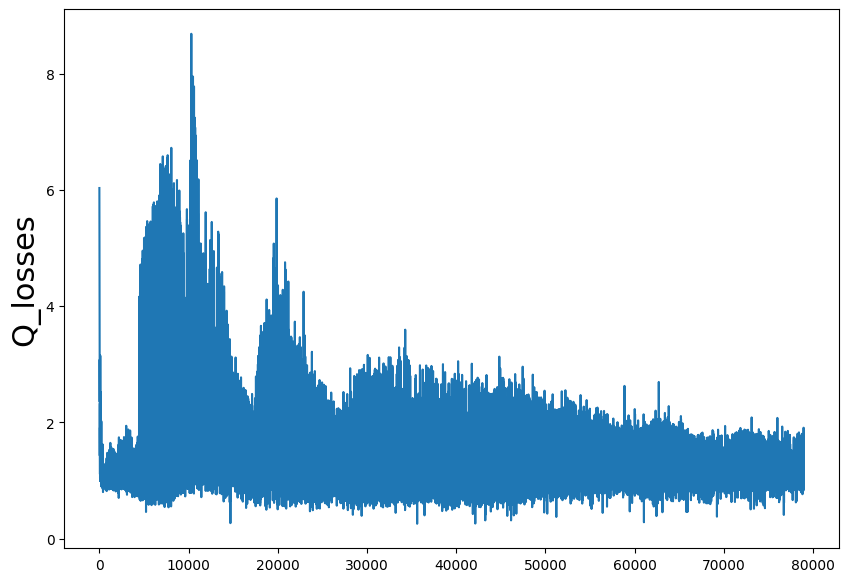

In [40]:
plt.figure(figsize=(10,7))
plt.plot(Q_losses)
plt.ylabel("Q_losses",fontsize=22)

Text(0, 0.5, 'mean_rewards')

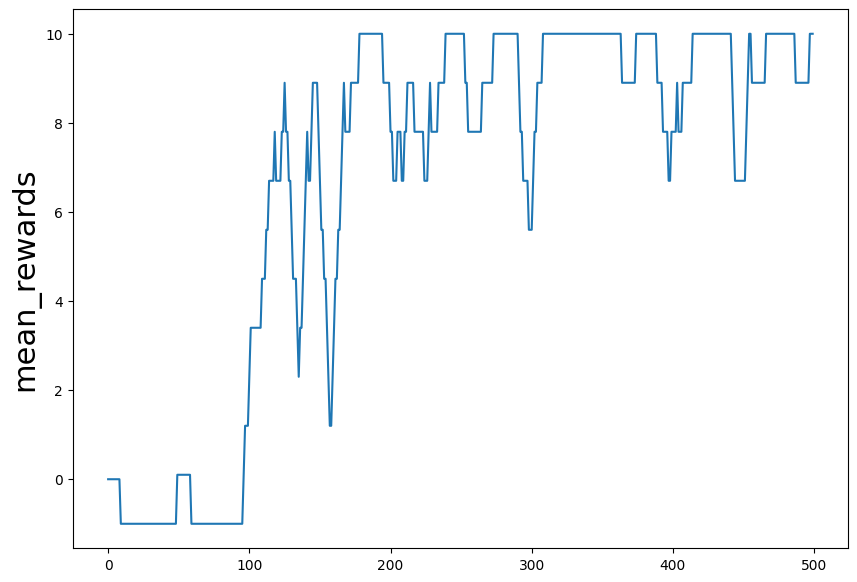

In [55]:
plt.figure(figsize=(10,7))
plt.plot(mean_rewards)
plt.ylabel("mean_rewards",fontsize=22)

In [56]:
episodes = 10
for i in range(episodes):
    game = gym.make('MountainCar-v0')
    state1 = game.reset()
    state1 = preprocess_state(state1,(1 ,input_shape) ,add_noise=False)
    
    
    state1 = torch.from_numpy(state1).float().to(device)
    gate = 1
    while(gate == 1):
        Q_val = Agent_NN(state1)
        Q_val_numpy = Q_val.detach().cpu().numpy()
        action = np.argmax(Q_val_numpy ,1)[0]
        state2 , reward ,done ,_ = game.step(action)
        
        state2 = preprocess_state(state2,(1 ,input_shape) ,add_noise=False)
        state2 = torch.from_numpy(state2).float().to(device)
        game.render()
        time.sleep(0.01)
        if done == True: 
            gate = 0
            game.close()
        state1 = state2

In [ ]:
plt.figure(figsize=(10,7))
plt.plot(mean_rewards)
plt.ylabel("mean_rewards",fontsize=22)

# Flappy-bird game  & Deep Q learning

In [41]:
import sys
sys.path.append("flappy-bird-gym/game")

In [42]:
from flappy_bird import GameState

pygame 2.1.2 (SDL 2.0.18, Python 3.8.15)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [43]:
env = GameState()

In [44]:
actions = {"up":[0,1] ,"do nothing":[1,0]}

In [45]:
state2 , r ,done = env.frame_step(actions["up"])

In [46]:
state2.shape

(288, 512, 3)

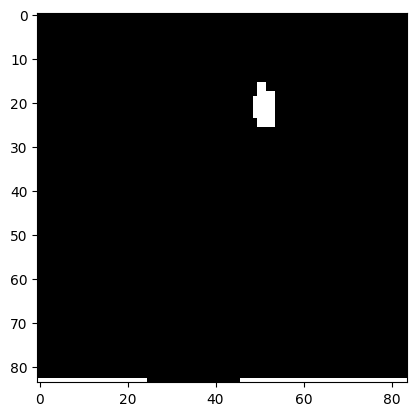

In [47]:
import matplotlib.pyplot as plt
import cv2
image = state2[0:288, 0:404]
image = cv2.cvtColor(cv2.resize(image, (84, 84)), cv2.COLOR_BGR2GRAY)
image[image > 0] = 255

image = np.reshape(image, (84, 84, 1))
plt.imshow(image ,cmap="gray")

In [48]:
def resize_and_bgr2gray(image):
    image = image[0:288, 0:404]
    image_data = cv2.cvtColor(cv2.resize(image, (84, 84)), cv2.COLOR_BGR2GRAY)
    image_data[image_data > 0] = 255
    image_data = np.reshape(image_data, (84, 84, 1))
    return image_data

In [49]:
class Conv_Q_Net(torch.nn.Module):
    def __init__(self, input_depth_length , output_shape):
        super(Conv_Q_Net, self).__init__()
        self.conv1 =   torch.nn.Conv2d(input_depth_length, 32, 8, stride=4)
        self.conv2 =   torch.nn.Conv2d(32, 64, 4,stride=2)
        self.conv3 =   torch.nn.Conv2d(64, 64, 3,stride=1)
        self.linear1 = torch.nn.Linear(3136, 512)
        self.linear2 = torch.nn.Linear(512 ,output_shape)
        self.flatten = torch.nn.Flatten()
        self.activation = torch.nn.ReLU()
        
    def forward(self ,x):
        x = self.conv1(x)
        x = self.activation(x)
        x = self.conv2(x)
        x = self.activation(x)
        x = self.conv3(x)
        x = self.activation(x)
        x = self.flatten(x)
        x = self.linear1(x)
        x = self.activation(x)
        x = self.linear2(x)
        return x   

In [50]:
device = "cuda"
input_depth_length = 1
output_shape = len(actions)
Agent_Q_Net = Conv_Q_Net(input_depth_length ,output_shape).to(device)


In [51]:
Agent_Q_Net

Conv_Q_Net(
  (conv1): Conv2d(1, 32, kernel_size=(8, 8), stride=(4, 4))
  (conv2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (linear1): Linear(in_features=3136, out_features=512, bias=True)
  (linear2): Linear(in_features=512, out_features=2, bias=True)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (activation): ReLU()
)

In [53]:
from flappy_bird import GameState
env = GameState()
exp1 = env.frame_step([0,1]) # up
exp2 = env.frame_step([1,0]) # down

In [54]:
def resize_and_bgr2gray(image):
    image = image[0:288, 0:404]
    image_data = cv2.cvtColor(cv2.resize(image, (84, 84)), cv2.COLOR_BGR2GRAY)
    image_data[image_data > 0] = 255
    image_data = np.reshape(image_data, (84, 84, 1))
    return image_data

In [62]:
input_shape = (1 ,84 , 84)


In [ ]:
import copy
from collections import deque
mean_rewards = []
output_shape = len(actions)
memory_size = 10000
batch_size = 64
replay = deque(maxlen=memory_size)
sync_freq = 20
gamma = 0.99
learning_rate = 1e-6
epochs = 10000
device="cuda:0"
losses = [] 
input_shape = (1 ,84 , 84)
input_depth_length = 4 
Agent = Conv_Q_Net(input_depth_length ,output_shape).to(device)
target_network = copy.deepcopy(Agent) 
target_network.load_state_dict(Agent.state_dict()) 

optimizer = torch.optim.Adam(Agent.parameters(), lr=learning_rate)
loss_fn = torch.nn.MSELoss()
epsilon = 0.2
mean_reward = 0
episodes_reward = []
for i in range(epochs):
    game = GameState()
    action = np.array([1,0])
    state1 ,reward ,done = game.frame_step(action)
    state1 = resize_and_bgr2gray(state1)
    state1 = preprocess_state(state1 ,input_shape ,add_noise = True)
    state1 = torch.from_numpy(state1).float().to(device)

    state1 = torch.cat((state1, state1, state1, state1),dim=0).unsqueeze(0)
    status = 1 
    k = 0
    pass_count = 0
    while(status == 1):        
        k += 1
        qval = Agent(state1) 
        qval_ = qval.data.detach().cpu().numpy()
        action_idx = get_action(qval_ , 2,epsilon)
        action = np.array([0,0])
        action[action_idx] = 1
        state2 ,reward ,done = game.frame_step(action)
        if reward == 10:
            pass_count += 1
        state2 = resize_and_bgr2gray(state2)
        state2 = preprocess_state(state2 ,input_shape ,add_noise = True)
        state2 = torch.from_numpy(state2).float().to(device)
        state2 = torch.cat((state1.squeeze(0)[1:, :, :], state2) ,dim=0).unsqueeze(0)
        exp =  (state1, action_idx, reward, state2, done)
        replay.append(exp) 
        if len(replay) > batch_size: 
            state1_batch ,action_batch ,reward_batch ,state2_batch ,done_batch = get_batch(replay ,batch_size ,device)
            Q1 = Agent(state1_batch) 
            with torch.no_grad():
                Q2 = target_network(state2_batch) #B

            maxQ = torch.max(Q2 ,axis = 1)[0]
            Y = batch_target(reward_batch ,gamma ,maxQ ,done_batch)
            X = Q1.gather(dim=1,index=action_batch.unsqueeze(dim=1)).squeeze()
            loss = loss_fn(X, Y) 
            print("mean_reward:",mean_reward)
            print(i ,loss.item())
            clear_output(wait=True)
            losses.append(loss.item())
            update(loss ,optimizer)
                   
        state1 = state2
        if k % sync_freq == 0:         
            target_network.load_state_dict(Agent.state_dict())
        if done == True or pass_count == 30: 
            episodes_reward.append(pass_count * 10)
            mean_reward = reward_metric(episodes_reward , 10)
            mean_rewards.append(mean_reward)   
            status = 0
    if epsilon > 0.0001: 
        epsilon -= (1/epochs)

In [ ]:
plt.figure(figsize=(10,7))
plt.plot(losses)
plt.xlabel("Epochs",fontsize=22)
plt.ylabel("Q_Losses",fontsize=22)

Text(0, 0.5, 'mean_rewards')

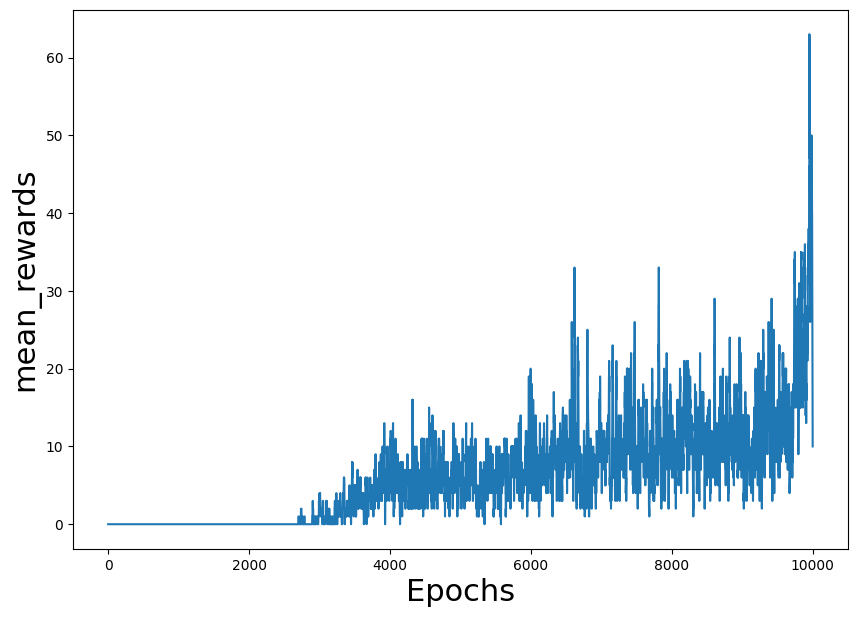

In [96]:
plt.figure(figsize=(10,7))
plt.plot(mean_rewards)
plt.xlabel("Epochs",fontsize=22)
plt.ylabel("mean_rewards",fontsize=22)

In [38]:
#torch.save(Agent, "conv_Q_Net.pt")
#Agent = torch.load("conv_Q_Net.pt")

In [42]:
episodes = 1000
for i in range(episodes):
    game = GameState()
    action = [0,1]
    state1 , reward ,done  = game.frame_step(action)
    state1 = resize_and_bgr2gray(state1)
    state1 = preprocess_state(state1,input_shape ,add_noise=True)
    state1 = torch.from_numpy(state1).float().to(device)
    state1 = torch.cat((state1, state1, state1, state1),dim=0).unsqueeze(0)

    gate = 1
    mov = 0
    while(gate == 1):
        Q_val = Agent(state1)
        Q_val_numpy = Q_val.detach().cpu().numpy()
        action = action = np.argmax(Q_val_numpy ,1)[0]
        if action == 1:
            action = [0,1]
        else:
            action = [1,0]
        state2 , reward ,done  = game.frame_step(action)
        state2 = resize_and_bgr2gray(state2)
        state2 = preprocess_state(state2,input_shape ,add_noise=True)
        state2 = torch.from_numpy(state2).float().to(device)
        state2 = torch.cat((state1.squeeze(0)[1:, :, :], state2) ,dim=0).unsqueeze(0)

        time.sleep(0.01)
        if done == True: 
            gate = 0
        state1 = state2


KeyboardInterrupt: 

### <font color='red'>2-steps Q network</font> 


In [47]:
def get_batch_for_2steps_dqn(replay ,batch_size ,device = "cpu"):
    minibatch = random.sample(replay, batch_size)
    state1_batch = torch.cat([s1 for (s1,s2,s3,a1,a2,r1,r2,d1,d2) in minibatch]).to(device)
    state2_batch = torch.cat([s2 for (s1,s2,s3,a1,a2,r1,r2,d1,d2) in minibatch]).to(device)
    state3_batch = torch.cat([s3 for (s1,s2,s3,a1,a2,r1,r2,d1,d2) in minibatch]).to(device)

    action1_batch = torch.Tensor([a1 for (s1,s2,s3,a1,a2,r1,r2,d1,d2) in minibatch]).long().to(device)
    action2_batch = torch.Tensor([a2 for (s1,s2,s3,a1,a2,r1,r2,d1,d2) in minibatch]).long().to(device)

    reward1_batch = torch.Tensor([r1 for (s1,s2,s3,a1,a2,r1,r2,d1,d2) in minibatch]).to(device)
    reward2_batch = torch.Tensor([r2 for (s1,s2,s3,a1,a2,r1,r2,d1,d2) in minibatch]).to(device)

    done1_batch = torch.Tensor([d1 for (s1,s2,s3,a1,a2,r1,r2,d1,d2) in minibatch]).to(device)
    done2_batch = torch.Tensor([d2 for (s1,s2,s3,a1,a2,r1,r2,d1,d2) in minibatch]).to(device)

    return state1_batch ,state2_batch ,state3_batch ,action1_batch ,action2_batch ,reward1_batch ,reward2_batch ,done1_batch ,done2_batch   

In [50]:
def batch_target_for_2steps_dqn(reward1_batch ,reward2_batch ,gamma , maxQ,done1_batch,done2_batch): 
    Y = reward1_batch + (gamma * ((reward2_batch + gamma * maxQ) * (1 - done2_batch)) * (1 - done1_batch))
    return Y

In [51]:
import copy
from collections import deque
mean_rewards = []
output_shape = len(actions)
memory_size = 10000
batch_size = 64
replay = deque(maxlen=memory_size)
sync_freq = 20
gamma = 0.99
learning_rate = 1e-6
epochs = 10000
device="cuda:0"
losses = [] 
input_shape = (1 ,84 , 84)
input_depth_length = 4 
Agent = Conv_Q_Net(input_depth_length ,output_shape).to(device)
target_network = copy.deepcopy(Agent) 
target_network.load_state_dict(Agent.state_dict()) 

optimizer = torch.optim.Adam(Agent.parameters(), lr=learning_rate)
loss_fn = torch.nn.MSELoss()
epsilon = 0.2
mean_reward = 0
episodes_reward = []
for i in range(epochs):
    game = GameState()
    action = np.array([1,0])
    state1 ,reward ,done = game.frame_step(action)
    state1 = resize_and_bgr2gray(state1)
    state1 = preprocess_state(state1 ,input_shape ,add_noise = True)
    state1 = torch.from_numpy(state1).float().to(device)

    state1 = torch.cat((state1, state1, state1, state1),dim=0).unsqueeze(0)
    status = 1 
    k = 0
    pass_count = 0
    while(status == 1):        
        k += 1
        qval = Agent(state1).detach()
        qval_ = qval.data.detach().cpu().numpy()
        action_idx1 = get_action(qval_ , 2,epsilon)
        action = np.array([0,0])
        action[action_idx1] = 1
        state2 ,reward1 ,done1 = game.frame_step(action)
        if reward1 == 10:
            pass_count += 1
        state2 = resize_and_bgr2gray(state2)
        state2 = preprocess_state(state2 ,input_shape ,add_noise = True)
        state2 = torch.from_numpy(state2).float().to(device)
        state2 = torch.cat((state1.squeeze(0)[1:, :, :], state2) ,dim=0).unsqueeze(0)
        if done1 == False:
            qval = target_network(state2).detach()
            qval_ = qval.data.detach().cpu().numpy()
            action_idx2 = get_action(qval_ , 2,-1)
            action = np.array([0,0])
            action[action_idx2] = 1
            state3 ,reward2 ,done2 = game.frame_step(action)
            if reward2 == 10:
                pass_count += 1
            state3 = resize_and_bgr2gray(state3)
            state3 = preprocess_state(state3 ,input_shape ,add_noise = True)
            state3 = torch.from_numpy(state3).float().to(device)
            state3 = torch.cat((state2.squeeze(0)[1:, :, :], state3) ,dim=0).unsqueeze(0)
            exp =  (state1 ,state2 ,state3 ,action_idx1 ,action_idx2 ,reward1, reward2, done1 ,done2)
        else:
            exp =  (state1 ,state2 ,state2 ,action_idx1 ,action_idx1 ,reward1, reward1, True ,True)

        replay.append(exp) 
        if len(replay) > batch_size: 
            state1_batch ,state2_batch ,state3_batch,\
            action1_batch,action2_batch,\
            reward1_batch,reward2_batch,done1_batch,done2_batch = get_batch_for_2steps_dqn(replay ,batch_size ,device)
            Q1 = Agent(state1_batch) 
            
            with torch.no_grad():
                Q3 = target_network(state3_batch)

            maxQ = torch.max(Q3 ,axis = 1)[0]
            Y = batch_target_for_2steps_dqn(reward1_batch ,reward2_batch ,gamma ,maxQ ,done1_batch ,done2_batch)
            X = Q1.gather(dim=1,index=action1_batch.unsqueeze(dim=1)).squeeze()
            
            loss = loss_fn(X, Y.detach()) 
            print("mean_reward:",mean_reward)
            print(i ,loss.item())
            clear_output(wait=True)
            losses.append(loss.item())
            update(loss ,optimizer)
                   
        state1 = state3
        if k % sync_freq == 0:         
            target_network.load_state_dict(Agent.state_dict())
            
        if done1 == True or done2 == True or pass_count == 30: 
            episodes_reward.append(pass_count * 10)
            mean_reward = reward_metric(episodes_reward , 10)
            mean_rewards.append(mean_reward)   
            status = 0
            
    if epsilon > 0.0001: 
        epsilon -= (1/epochs)

mean_reward: 64.0
9384 1.8263492584228516


KeyboardInterrupt: 

Text(0, 0.5, 'mean_rewards')

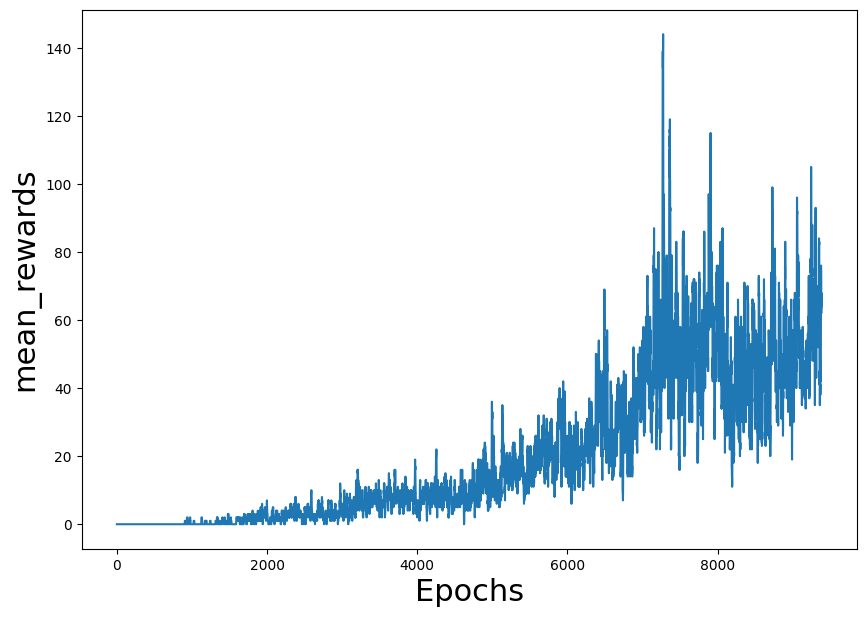

In [52]:
plt.figure(figsize=(10,7))
plt.plot(mean_rewards)
plt.xlabel("Epochs",fontsize=22)
plt.ylabel("mean_rewards",fontsize=22)

### <font color='red'>dueling Q network</font> 


In [103]:
class dueling_Conv_Q_Net(torch.nn.Module):
    def __init__(self, input_depth_length , output_shape):
        super(dueling_Conv_Q_Net, self).__init__()
        self.conv1 =   torch.nn.Conv2d(input_depth_length, 32, 8, stride=4)
        self.conv2 =   torch.nn.Conv2d(32, 64, 4,stride=2)
        self.conv3 =   torch.nn.Conv2d(64, 64, 3,stride=1)
        self.state_value_linear1 = torch.nn.Linear(3136, 200)
        self.state_value_linear2 = torch.nn.Linear(200, 1)
        
        self.advantage_linear1 = torch.nn.Linear(3136 ,200)
        self.advantage_linear2 = torch.nn.Linear(200 ,output_shape)

        self.flatten = torch.nn.Flatten()
        self.activation = torch.nn.ReLU()
        
    def forward(self ,x):
        x = self.conv1(x)
        x = self.activation(x)
        x = self.conv2(x)
        x = self.activation(x)
        x = self.conv3(x)
        x = self.activation(x)
        x = self.flatten(x)
        
        x_state_val = self.state_value_linear1(x)
        x_state_val = self.activation(x_state_val)
        x_state_val = self.state_value_linear2(x_state_val)
        
        x_advantage = self.advantage_linear1(x)
        x_advantage = self.activation(x_advantage)
        x_advantage = self.advantage_linear2(x_advantage)       
        
        y = x_state_val + x_advantage - x_advantage.mean(dim=1).unsqueeze(1)
        return y   

In [104]:
import copy
from collections import deque
mean_rewards = []
output_shape = len(actions)
memory_size = 10000
batch_size = 64
replay = deque(maxlen=memory_size)
sync_freq = 20
gamma = 0.99
learning_rate = 1e-6
epochs = 10000
device="cuda:0"
losses = [] 
input_shape = (1 ,84 , 84)
input_depth_length = 4 
Agent = dueling_Conv_Q_Net(input_depth_length ,output_shape).to(device)
target_network = copy.deepcopy(Agent) 
target_network.load_state_dict(Agent.state_dict()) 

optimizer = torch.optim.Adam(Agent.parameters(), lr=learning_rate)
loss_fn = torch.nn.MSELoss()
epsilon = 0.2
mean_reward = 0
episodes_reward = []
for i in range(epochs):
    game = GameState()
    action = np.array([1,0])
    state1 ,reward ,done = game.frame_step(action)
    state1 = resize_and_bgr2gray(state1)
    state1 = preprocess_state(state1 ,input_shape ,add_noise = True)
    state1 = torch.from_numpy(state1).float().to(device)

    state1 = torch.cat((state1, state1, state1, state1),dim=0).unsqueeze(0)
    status = 1 
    k = 0
    pass_count = 0
    while(status == 1):        
        k += 1
        qval = Agent(state1) 
        qval_ = qval.data.detach().cpu().numpy()
        action_idx = get_action(qval_ , 2,epsilon)
        action = np.array([0,0])
        action[action_idx] = 1
        state2 ,reward ,done = game.frame_step(action)
        if reward == 10:
            pass_count += 1
        state2 = resize_and_bgr2gray(state2)
        state2 = preprocess_state(state2 ,input_shape ,add_noise = True)
        state2 = torch.from_numpy(state2).float().to(device)
        state2 = torch.cat((state1.squeeze(0)[1:, :, :], state2) ,dim=0).unsqueeze(0)
        exp =  (state1, action_idx, reward, state2, done)
        replay.append(exp) 
        if len(replay) > batch_size: 
            state1_batch ,action_batch ,reward_batch ,state2_batch ,done_batch = get_batch(replay ,batch_size ,device)
            Q1 = Agent(state1_batch) 
            with torch.no_grad():
                Q2 = target_network(state2_batch) #B

            maxQ = torch.max(Q2 ,axis = 1)[0]
            Y = batch_target(reward_batch ,gamma ,maxQ ,done_batch)
            X = Q1.gather(dim=1,index=action_batch.unsqueeze(dim=1)).squeeze()
            loss = loss_fn(X, Y) 
            print("mean_reward:",mean_reward)
            print(i ,loss.item())
            clear_output(wait=True)
            losses.append(loss.item())
            update(loss ,optimizer)
                   
        state1 = state2
        
        if k % sync_freq == 0:         
            target_network.load_state_dict(Agent.state_dict())
            
        if done == True or pass_count == 30: 
            episodes_reward.append(pass_count * 10)
            mean_reward = reward_metric(episodes_reward , 10)
            mean_rewards.append(mean_reward)   
            status = 0
    if epsilon > 0.0001: 
        epsilon -= (1/epochs)

KeyboardInterrupt: 

Text(0, 0.5, 'mean_rewards')

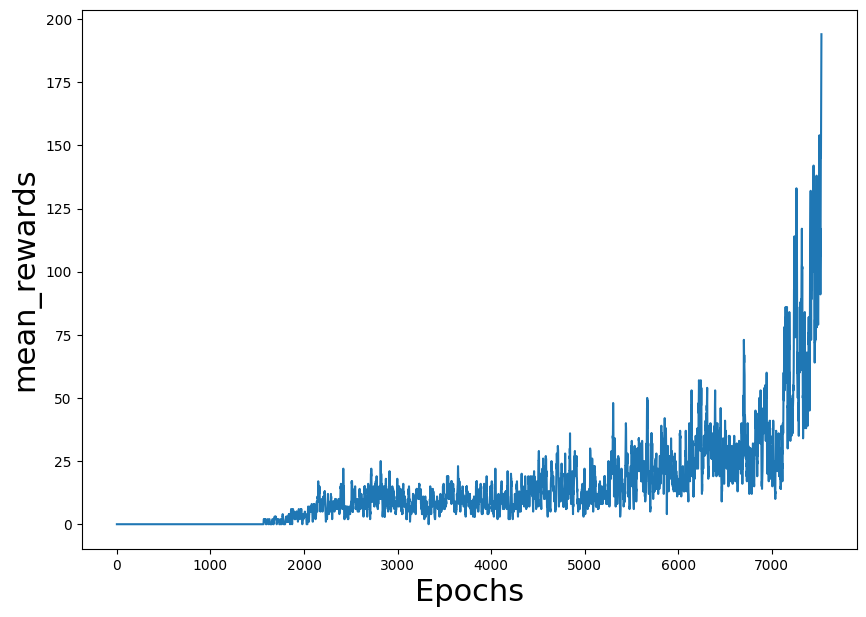

In [105]:
plt.figure(figsize=(10,7))
plt.plot(mean_rewards)
plt.xlabel("Epochs",fontsize=22)
plt.ylabel("mean_rewards",fontsize=22)

### <font color='red'>Prioritized replay buffer</font> 


In [151]:
def get_batch_based_on_priorities(replay ,batch_size ,priorities_list ,alpha=0.6 ,beta=0.4 ,device = "cpu"):
        probabilities = (np.array(priorities_list)**alpha) / (((np.array(priorities_list))**alpha).sum())
        minibatch_idx = np.random.choice(len(replay),batch_size, p=probabilities)
        minibatch = [replay[idx] for idx in minibatch_idx]
        state1_batch = torch.cat([s1 for (s1,a,r,s2,d) in minibatch]).to(device)
        action_batch = torch.Tensor([a for (s1,a,r,s2,d) in minibatch]).long().to(device)
        reward_batch = torch.Tensor([r for (s1,a,r,s2,d) in minibatch]).to(device)
        state2_batch = torch.cat([s2 for (s1,a,r,s2,d) in minibatch]).to(device)
        done_batch = torch.Tensor([d for (s1,a,r,s2,d) in minibatch]).to(device)
        N = len(replay)
        weights = ((1/N) * (1/probabilities[minibatch_idx])) ** (beta)
        weights /= weights.max()
        return state1_batch ,action_batch ,reward_batch ,state2_batch ,done_batch ,minibatch_idx ,weights  
    

In [60]:
import copy
from collections import deque

mean_rewards = []
output_shape = len(actions)
memory_size = 10000
batch_size = 200

replay = deque(maxlen=memory_size)
priorities_list = []
sync_freq = 20
gamma = 0.99
learning_rate = 1e-6
epochs = 10000
device="cuda:0"
Q_losses = [] 
input_shape = (1 ,84 , 84)
input_depth_length = 4 
Agent = Conv_Q_Net(input_depth_length ,output_shape).to(device)
target_network = copy.deepcopy(Agent) 
target_network.load_state_dict(Agent.state_dict()) 

optimizer = torch.optim.Adam(Agent.parameters(), lr=learning_rate)
loss_fn = torch.nn.MSELoss(reduction="none")
epsilon = 0.2
mean_reward = 0
episodes_reward = []
beta_start = 0.4
beta = beta_start
alpha = 0.6

for i in range(epochs):
    game = GameState()
    action = np.array([1,0])
    state1 ,reward ,done = game.frame_step(action)
    state1 = resize_and_bgr2gray(state1)
    state1 = preprocess_state(state1 ,input_shape ,add_noise = True)
    state1 = torch.from_numpy(state1).float().to(device)
    state1 = torch.cat((state1, state1, state1, state1),dim=0).unsqueeze(0)
    status = 1 
    k = 0
    pass_count = 0
    while(status == 1):        
        k += 1
        qval = Agent(state1)
        qval_ = qval.data.detach().cpu().numpy()
        action_idx = get_action(qval_ , 2,epsilon)
        action = np.array([0,0])
        action[action_idx] = 1
        state2 ,reward ,done = game.frame_step(action)
        if reward == 10:
            pass_count += 1
        state2 = resize_and_bgr2gray(state2)
        state2 = preprocess_state(state2 ,input_shape ,add_noise = True)
        state2 = torch.from_numpy(state2).float().to(device)
        state2 = torch.cat((state1.squeeze(0)[1:, :, :], state2) ,dim=0).unsqueeze(0)
        exp =  (state1, action_idx, reward, state2, done)
        replay.append(exp) 

        if len(priorities_list) < memory_size:
            if len(priorities_list) <= batch_size:
                priorities_list.append(1)
            else:
                priorities_list.append(max(priorities_list))
        else:
            priorities_list.pop(0)
            priorities_list.append(max(priorities_list))
           

        if len(replay) >= batch_size: 
            state1_batch ,action_batch ,reward_batch ,state2_batch ,done_batch,idx_batch ,weights = get_batch_based_on_priorities(replay = replay ,
                                                                                                                                  batch_size = batch_size,
                                                                                                                                  priorities_list = priorities_list,
                                                                                                                                  alpha=0.6,
                                                                                                                                  beta=beta,device=device)
            Q1 = Agent(state1_batch) 
            with torch.no_grad():
                Q2 = target_network(state2_batch) 

            maxQ = torch.max(Q2 ,axis = 1)[0]
            Y = batch_target(reward_batch ,gamma ,maxQ ,done_batch)
            X = Q1.gather(dim=1,index=action_batch.unsqueeze(dim=1)).squeeze()
            losses = loss_fn(X, Y) 
            
            priorities = (losses.detach()).cpu().numpy() * weights + 1e-6

            for priority ,idx in zip(list(priorities) ,idx_batch):
                priorities_list[idx] = priority

            loss = losses.mean()
            print("mean_reward:",mean_reward)
            print(i ,loss.item())
            clear_output(wait=True)
            Q_losses.append(loss.item())
            update(loss ,optimizer)
                   
        state1 = state2
        if k % sync_freq == 0:         
            target_network.load_state_dict(Agent.state_dict())
            
        if done == True or pass_count == 30: 
            episodes_reward.append(pass_count * 10)
            mean_reward = reward_metric(episodes_reward , 10)
            mean_rewards.append(mean_reward)   
            status = 0
            
    if epsilon > 0.0001: 
        epsilon -= (1/epochs)
        
    beta = beta_start + (1 - beta_start) * (i / epochs)    

KeyboardInterrupt: 

Text(0, 0.5, 'mean_rewards')

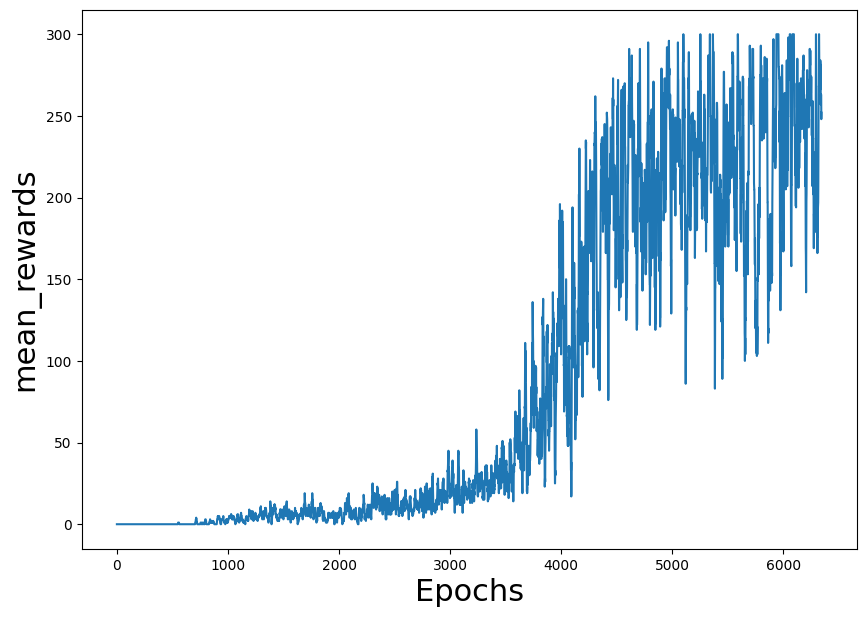

In [109]:
plt.figure(figsize=(10,7))
plt.plot(mean_rewards)
plt.xlabel("Epochs",fontsize=22)
plt.ylabel("mean_rewards",fontsize=22)

In [55]:
while(os.getcwd().split('\\')[-1] != "RL"):
      os.chdir(os.path.dirname(os.getcwd()))

## Ms Pacman  & Deep Q learning

In [56]:
import retro 
import time
import cv2
import matplotlib.pyplot as plt

In [57]:
env = retro.make("MsPacman-Atari2600")

In [58]:
env.observation_space.sample().shape

(210, 160, 3)

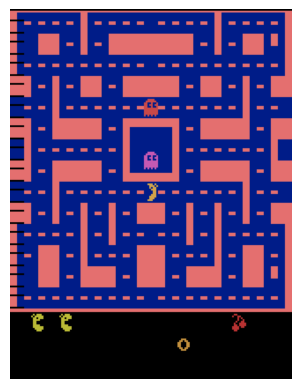

In [59]:
img  = env.reset()
plt.axis(False)
plt.imshow(img);

In [60]:
gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

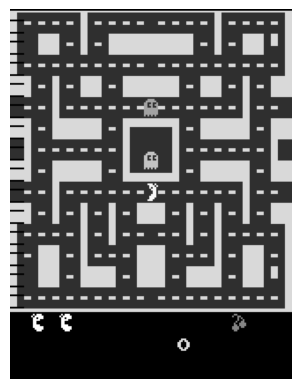

In [61]:
plt.axis(False)
plt.imshow(gray_img ,cmap="gray");

In [25]:
gray_img.shape

(210, 160)

In [26]:
resized_gray_img = cv2.resize(gray_img, (84, 84))   


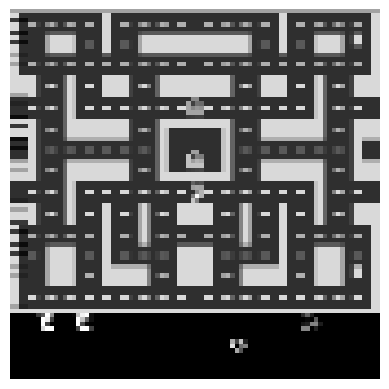

In [27]:
plt.axis(False)
plt.imshow(resized_gray_img ,cmap="gray");

In [28]:
actions = {0:"UP",1:"DOWN",2:"LEFT",3:"UP-LEFT",4:"DOWN-LEFT",5: "RIGHT",6:"UP-RIGHT",7:"DOWN-RIGHT"}

actions_emb = {'UP':[0 ,0 ,0 ,0 ,1 ,0 ,0 ,0],
               'DOWN':[0 ,0 ,0 ,0 ,0 ,1 ,0 ,0],
               'LEFT':[0 ,0 ,0 ,0 ,0 ,0 ,1 ,0],
               'UP-LEFT':[0 ,0 ,0 ,0 ,1 ,0 ,1 ,0],
               'DOWN-LEFT':[0 ,0 ,0 ,0 ,0 ,1 ,1 ,0],
               'RIGHT':[0 ,0 ,0 ,0 ,0 ,0 ,0 ,1],
               'UP-RIGHT':[0 ,0 ,0 ,0 ,1 ,0 ,0 ,1],
               'DOWN-RIGHT':[0 ,0 ,0 ,0 ,0 ,1 ,0 ,1],
               }

In [29]:
def resize_rgb2gray(image):
    gray_img = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    resized_gray_img = cv2.resize(gray_img, (84, 84))   
    resized_gray_img = np.reshape(resized_gray_img, (resized_gray_img.shape[0], resized_gray_img.shape[1], 1))
    return resized_gray_img

In [ ]:
status = 1
skip = False
skip2 = False
done = False
s = env.reset()
while(status == 1):
    
    while(skip==False):
        _,_,d,info = env.step(actions_emb["LEFT"])
        if info['score'] >= 10:
            skip = True
            
    _,_,d,info = env.step(actions_emb["LEFT"])
    time.sleep(0.000001)
  
    if info['deathTimer'] == 74 and info['lives'] == 0:
        done = True
    else: 
        done = False
        
    if info['deathTimer'] == 74 and done == False:
        while True:
              _ ,_ , d ,info = env.step(actions_emb['LEFT'])
              if info['deathTimer'] == 255:
                 break
            
    env.render()
    if done:
        skip = False
        env.reset()
        status = 0

In [30]:

actions = {0:"UP",1:"DOWN",2:"LEFT",3:"UP-LEFT",4:"DOWN-LEFT",5: "RIGHT",6:"UP-RIGHT",7:"DOWN-RIGHT"}

actions_emb = {'UP':[0 ,0 ,0 ,0 ,1 ,0 ,0 ,0],
               'DOWN':[0 ,0 ,0 ,0 ,0 ,1 ,0 ,0],
               'LEFT':[0 ,0 ,0 ,0 ,0 ,0 ,1 ,0],
               'UP-LEFT':[0 ,0 ,0 ,0 ,1 ,0 ,1 ,0],
               'DOWN-LEFT':[0 ,0 ,0 ,0 ,0 ,1 ,1 ,0],
               'RIGHT':[0 ,0 ,0 ,0 ,0 ,0 ,0 ,1],
               'UP-RIGHT':[0 ,0 ,0 ,0 ,1 ,0 ,0 ,1],
               'DOWN-RIGHT':[0 ,0 ,0 ,0 ,0 ,1 ,0 ,1],
               }

In [31]:
env.close()

In [32]:
def resize_rgb2gray(image):
    gray_img = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    resized_gray_img = cv2.resize(gray_img, (84, 84))   
    resized_gray_img = np.reshape(resized_gray_img, (resized_gray_img.shape[0], resized_gray_img.shape[1], 1))
    return resized_gray_img

In [33]:
len(actions)

8

## <font color='red'>basic Q network  </font> 


In [34]:
import torch
class Conv_Q_Net(torch.nn.Module):
    def __init__(self, input_depth_length , output_shape):
        super(Conv_Q_Net, self).__init__()
        self.conv1 =   torch.nn.Conv2d(input_depth_length, 32, 8, stride=4)
        self.conv2 =   torch.nn.Conv2d(32, 64, 4,stride=2)
        self.conv3 =   torch.nn.Conv2d(64, 64, 3,stride=1)
        self.linear1 = torch.nn.Linear(3136 , 128)
        self.linear2 = torch.nn.Linear(128 ,output_shape)
        self.flatten = torch.nn.Flatten()
        self.activation = torch.nn.ReLU()
        
    def forward(self ,x):
        x = self.conv1(x)
        x = self.activation(x)
        x = self.conv2(x)
        x = self.activation(x)
        x = self.conv3(x)
        x = self.activation(x)
        x = self.flatten(x)
        x = self.linear1(x)
        x = self.activation(x)
        x = self.linear2(x)
        return x   

In [22]:
import copy
from collections import deque
import numpy as np
mean_rewards = []
output_shape = len(actions)
memory_size = 300000
batch_size =  32
nb_steps_warmup=  50000
replay = deque(maxlen=memory_size)
sync_freq = 10000
gamma = 0.99
lr =  0.00025
epochs = 1500
device="cuda"
mean_reward = 0
Q_losses = [] 
input_shape = (1 ,84, 84)
input_depth_length = 4
Agent = Conv_Q_Net(input_depth_length, output_shape).to(device)
target_network = copy.deepcopy(Agent) 
target_network.load_state_dict(Agent.state_dict()) 

optimizer = torch.optim.Adam(Agent.parameters(), lr = lr)

loss_fn = torch.nn.HuberLoss(delta=1.0)
max_epsilon = 1.
min_epsilon = 0.1

epsilon = max_epsilon

exploration_steps = 1250000
episodes_reward = []
train_intervel = 4
k = 0
game = retro.make("MsPacman-Atari2600")

for i in range(epochs):
    state1 = game.reset()


    while True:
        state1 ,reward , done ,info = game.step(actions_emb['LEFT'])
        if info['score'] == 10:
            break

    state1 = resize_rgb2gray(state1)
    state1 = preprocess_state(state1 ,input_shape ,add_noise = False)
    state1 = torch.from_numpy(state1).float()
    state1 = state1 / 255.
    state1 = torch.cat((state1, state1, state1 ,state1),dim=0).unsqueeze(0)
    status = 1 
    
    current_episode_step = 0
    small_rect_count = 0
    while(status == 1):
        game.render()
        k += 1
        current_episode_step += 1
        
        with torch.no_grad():      
            qval = Agent(state1.to(device)) 
            qval_ = qval.data.detach().cpu().numpy()
            
        action_idx = get_action(qval_ , 8,epsilon)
        action_name = actions[action_idx]
        action = actions_emb[action_name]
        state2 ,reward , _ ,info = game.step(action)

        if info['lives'] == 0 and info['deathTimer'] == 74:
            done = True
        else:
            done = False


        if reward > 0:
            small_rect_count += 1 
            reward = 1
            
        if info['deathTimer'] == 74 and info['lives'] > 0:
            reward = -0.1
            

        if info['deathTimer'] == 74 and info['lives'] == 0:
            reward = -1
            
        state2 = resize_rgb2gray(state2) 
        state2 = preprocess_state(state2 ,input_shape ,add_noise = False)
        state2 = torch.from_numpy(state2).float()
        state2 = state2 / 255.
        state2 = torch.cat((state1.squeeze(0)[1:, :, :], state2) ,dim=0).unsqueeze(0)
        exp =  (state1, action_idx, reward, state2, done)
        replay.append(exp)
        
        if info['deathTimer'] == 74 and done == False:
            while True:
                _ ,reward , _ ,info = game.step(actions_emb['LEFT'])
                if info['deathTimer'] == 255:
                    break
            
          
        if len(replay) > nb_steps_warmup and k % train_intervel == 0:
            state1_batch ,action_batch ,reward_batch ,state2_batch ,done_batch = get_batch(replay ,batch_size ,device)

            Q1 = Agent(state1_batch) 
            
            with torch.no_grad():
                Q2 = target_network(state2_batch) 
            maxQ = torch.max(Q2 ,axis = 1)[0]
            
            Y = batch_target(reward_batch ,gamma ,maxQ ,done_batch)
            X = Q1.gather(dim=1,index=action_batch.unsqueeze(dim=1)).squeeze()
            loss = loss_fn(X, Y) 
            

            print("current step:" ,k)
            print("learning_rate" ,optimizer.param_groups[0]['lr'])
            print("mean_reward:",mean_reward)
            print(i ,loss.item())
            clear_output(wait=True)
            Q_losses.append(loss.item())
            update(loss ,optimizer)
            
        state1 = state2
        
        if k % sync_freq == 0:         
            target_network.load_state_dict(Agent.state_dict())
          
        if done == True or current_episode_step == 20000: 
            episodes_reward.append(small_rect_count)
            mean_reward = reward_metric(episodes_reward , 10)
            mean_rewards.append(mean_reward)   
            status = 0
        
    if epsilon > min_epsilon: 
        epsilon = ((min_epsilon - max_epsilon)  / exploration_steps) * k + max_epsilon
        
    
game.close()


current step: 2383696
learning_rate 0.00025
mean_reward: 65.2
1499 0.013401404023170471


Text(0, 0.5, 'mean_rewards')

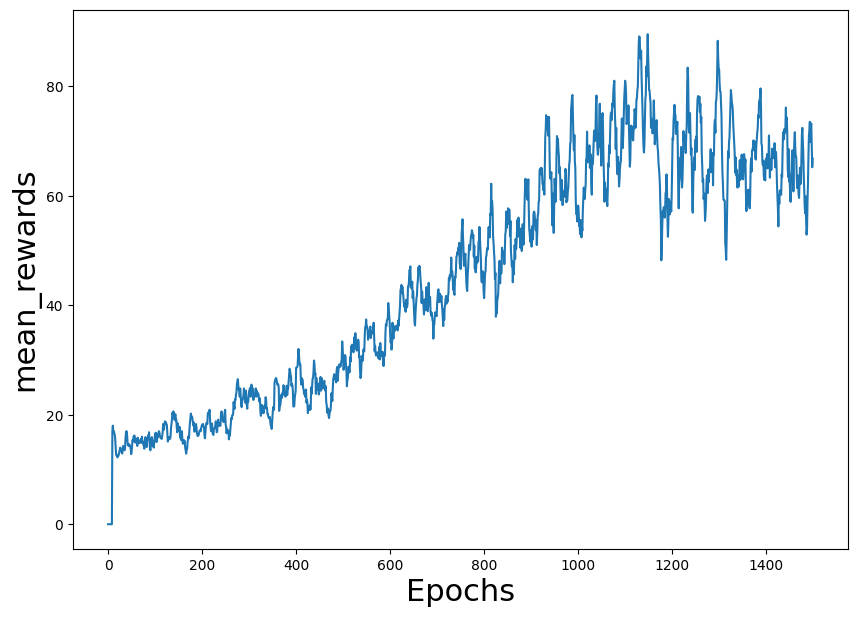

In [23]:
plt.figure(figsize=(10,7))
plt.plot(mean_rewards)
plt.xlabel("Epochs",fontsize=22)
plt.ylabel("mean_rewards",fontsize=22)

### <font color='red'> nsteps Q network Pacman </font> 

In [40]:
def get_batch_for_nsteps_dqn(replay ,batch_size ,nsteps = 1 ,device = "cpu"):
    
    if nsteps < 1:
        nsteps = 1
        
    minibatch_idx = random.sample(range(len(replay)), batch_size)
    minibatch = [replay[idx] for idx in minibatch_idx]
    nsteps_next_state_batch = []
    nsteps_reward_batch = []
    nsteps_done_batch = []
    
    state1_batch = torch.cat([s1 for (s1 ,a ,r ,s2 ,d) in minibatch]).float().to(device)
    action1_batch = torch.tensor([a for (s1 ,a ,r ,s2 ,d) in minibatch]).long().to(device)
    
    for exp_idx in minibatch_idx:
        nsteps_next_state = []
        nsteps_reward = []
        
        for step in range(nsteps):  
            exp = replay[exp_idx + step]
            s1 ,a ,r ,s2 ,d = exp
            nsteps_reward.append(r)
            
            if d == True or step == nsteps - 1 or exp_idx + step == len(replay) - 1 :
                nsteps_next_state_batch.append(s2)
                nsteps_done_batch.append(d)
                break
                
        nsteps_reward_batch.append(nsteps_reward)
       
    nsteps_next_state_batch = torch.cat([s for s in nsteps_next_state_batch]).float().to(device)
    nsteps_done_batch = torch.tensor(nsteps_done_batch).long().to(device)

    return state1_batch ,action1_batch ,nsteps_next_state_batch ,nsteps_reward_batch  ,nsteps_done_batch 
state1_batch ,action1_batch ,nsteps_next_state_batch ,nsteps_reward_batch ,nsteps_done_batch = get_batch_for_nsteps_dqn(replay =replay,
                                                                                                                                    batch_size = batch_size,
                                                                                                                                    nsteps=3 ,device=device)

            

In [41]:
def batch_target_for_nsteps_dqn(nsteps_reward_batch  ,gamma ,maxQ ,nsteps_done_batch ,device="cpu"): 
    Y_list = []
    for i , nsteps_reward in enumerate(nsteps_reward_batch):
        gamma_list = [gamma**i for i in range(len(nsteps_reward))]
        gamma_array = np.array(gamma_list)
        nsteps_reward = np.array(nsteps_reward)
        Y = torch.tensor(nsteps_reward * gamma_list).sum().to(device) + gamma**(len(nsteps_reward)) * maxQ[i] * (1 - nsteps_done_batch[i])
        Y_list.append(Y)
    return torch.tensor([Y for Y in Y_list]).float().to(device)

In [95]:
import copy
from collections import deque
import numpy as np
mean_rewards = []
output_shape = len(actions)
memory_size = 100000
batch_size =  32
nb_steps_warmup =  50000
replay = deque(maxlen=memory_size)
sync_freq = 10000
gamma = 0.99
lr =  0.00025
epochs = 1500
device="cuda"
mean_reward = 0
Q_losses = [] 
death_list = []
input_shape = (1 ,84, 84)
input_depth_length = 4
Agent = Conv_Q_Net(input_depth_length, output_shape).to(device)
target_network = copy.deepcopy(Agent) 
target_network.load_state_dict(Agent.state_dict()) 
optimizer = torch.optim.Adam(Agent.parameters(), lr = max_lr)
loss_fn = torch.nn.HuberLoss(delta=1.0)
max_epsilon = 1
min_epsilon = 0.1
epsilon = max_epsilon
exploration_steps = 1250000
episodes_reward = []
train_intervel = 4
k = 0
game = retro.make("MsPacman-Atari2600")

for i in range(epochs):
    state1 = game.reset()
    init_score = 0 
   
    while True:
        state1 ,reward , done ,info = game.step(actions_emb['LEFT'])
        if info['score'] == 10:
            break
    
    state1 = resize_rgb2gray(state1)
    state1 = preprocess_state(state1 ,input_shape ,add_noise = False)
    state1 = torch.from_numpy(state1).float()
    state1 = state1 / 255.
    state1 = torch.cat((state1 ,state1 ,state1 ,state1),dim=0).unsqueeze(0)
    status = 1 
    
    pass_count = 0
    pre_score = 0
    pre_live = 2
    previous_action = 0
    current_episode_step = 0
    
    while(status == 1):
        game.render()
        
        current_episode_step += 1
        
        with torch.no_grad():      
            qval = Agent(state1.to(device)) 
            qval_ = qval.data.detach().cpu().numpy()
            
        action_idx = get_action(qval_ , 8,epsilon)
        action_name = actions[action_idx]
        action = actions_emb[action_name]
        state2 ,reward , _ ,info = game.step(action)
        curr_live = info['lives']

        if info['lives'] == 0 and info['deathTimer'] == 74:
            done = True
        else:
            done = False
            
        
 
        if reward > 0:
            reward = 1
            pass_count += 1  
            
        if info['deathTimer'] == 74 and info['lives'] > 0:
            reward = -0.1
            
        if info['deathTimer'] == 74 and info['lives'] == 0:
            reward = -1
            
        pre_live = curr_live
        state2 = resize_rgb2gray(state2) 
        state2 = preprocess_state(state2 ,input_shape ,add_noise = False)
        state2 = torch.from_numpy(state2).float()
        state2 = state2 / 255.
        state2 = torch.cat((state1.squeeze(0)[1:, :, :], state2) ,dim=0).unsqueeze(0)
        exp =  (state1, action_idx, reward, state2, done)
        replay.append(exp)
        k += 1
        
        if info['deathTimer'] == 74 and done == False:
            while True:
                _ ,reward , _ ,info = game.step(actions_emb['LEFT'])
                if info['deathTimer'] == 255:
                    break
            
          
        if len(replay) > nb_steps_warmup and k % train_intervel == 0:
            state1_batch ,action1_batch ,nsteps_next_state_batch ,nsteps_reward_batch ,nsteps_done_batch = get_batch_for_nsteps_dqn(replay =replay,
                                                                                                                                    batch_size = batch_size,
                                                                                                                                    nsteps=3 ,device=device)

            Q1 = Agent(state1_batch) 
            
            with torch.no_grad():
                Q_nsteps_next_state = target_network(nsteps_next_state_batch)

            maxQ = torch.max(Q_nsteps_next_state ,axis = 1)[0]
            
            Y = batch_target_for_nsteps_dqn(nsteps_reward_batch  ,gamma ,maxQ ,nsteps_done_batch ,device=device)
            X = Q1.gather(dim=1,index=action1_batch.unsqueeze(dim=1)).squeeze()
            loss = loss_fn(X, Y.detach()) 
            

            print("current step:" ,k)
            print("learning_rate" ,optimizer.param_groups[0]['lr'])
            print("mean_reward:",mean_reward)
            print(i ,loss.item())
            clear_output(wait=True)
            Q_losses.append(loss.item())
            update(loss ,optimizer)
            
        previous_action = action     
        state1 = state2
        
        if k % sync_freq == 0:         
            target_network.load_state_dict(Agent.state_dict())
          
        if done == True or current_episode_step == 20000: 
            episodes_reward.append(pass_count)
            mean_reward = reward_metric(episodes_reward , 10)
            mean_rewards.append(mean_reward)   
            status = 0
        
    if epsilon > min_epsilon: 
        epsilon = ((min_epsilon - max_epsilon)  / exploration_steps) * k + max_epsilon
        
    
game.close()


RuntimeError: Cannot create multiple emulator instances per process, make sure to call env.close() on each environment before creating a new one

Text(0, 0.5, 'mean_rewards')

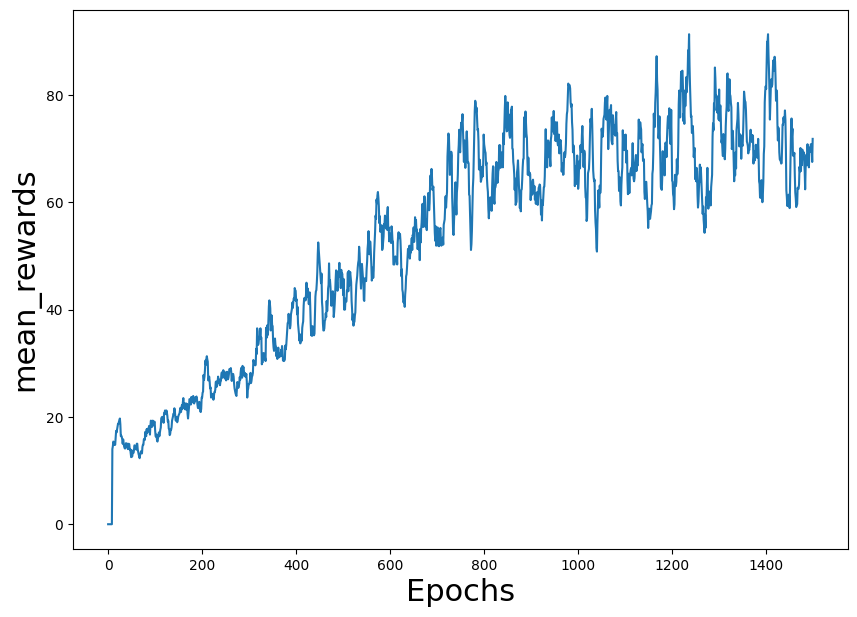

In [252]:
plt.figure(figsize=(10,7))
plt.plot(mean_rewards)
plt.xlabel("Epochs",fontsize=22)
plt.ylabel("mean_rewards",fontsize=22)

In [71]:
torch.save(Agent, "packman_agnet_nn.pt")
torch.save(target_network, "packman_target_nn.pt")

In [94]:
game.close()

### <font color='red'>n steps double dueling noisy Q network </font> 


In [32]:
import math
from torch.autograd import Variable

class NoisyLinearLayer(torch.nn.Linear):
    def __init__(self, in_features, out_features, sigma_init=0.06, bias=True):
        super(NoisyLinearLayer, self).__init__(in_features, out_features, bias=bias)
        self.sigma_weight = torch.nn.Parameter(torch.Tensor(out_features, in_features).fill_(sigma_init))
        self.register_buffer("epsilon_weight", torch.zeros(out_features, in_features))
        if bias:
            self.sigma_bias = torch.nn.Parameter(torch.Tensor(out_features).fill_(sigma_init))
            self.register_buffer("epsilon_bias", torch.zeros(out_features))
        self.reset_parameters()

    def reset_parameters(self):
        std = math.sqrt(3 / self.in_features)
        torch.nn.init.uniform_(self.weight, -std, std)
        torch.nn.init.uniform_(self.bias, -std, std)

    def forward(self, input):
        torch.randn(self.epsilon_weight.size(), out=self.epsilon_weight)
        bias = self.bias
        if bias is not None:
            torch.randn(self.epsilon_bias.size(), out=self.epsilon_bias)
            bias = bias + self.sigma_bias * Variable(self.epsilon_bias)
        return torch.nn.functional.linear(input, self.weight + self.sigma_weight * Variable(self.epsilon_weight), bias)

In [33]:
class dueling_noisy_Conv_Q_Net(torch.nn.Module):
    def __init__(self, input_depth_length , output_shape):
        super(dueling_noisy_Conv_Q_Net, self).__init__()
        self.conv1 =   torch.nn.Conv2d(input_depth_length, 32, 8, stride=4)
        self.conv2 =   torch.nn.Conv2d(32, 64, 4,stride=2)
        self.conv3 =   torch.nn.Conv2d(64, 64, 3,stride=1)
        
        self.state_value_linear1 =  NoisyLinearLayer(3136, 128)
        self.state_value_linear2 =  NoisyLinearLayer(128, 1)
        
        self.advantage_linear1 =  NoisyLinearLayer(3136 ,128)
        self.advantage_linear2 =  NoisyLinearLayer(128 ,output_shape)

        self.flatten = torch.nn.Flatten()
        self.activation = torch.nn.ReLU()
        
    def forward(self ,x):
        x = self.conv1(x)
        x = self.activation(x)
        x = self.conv2(x)
        x = self.activation(x)
        x = self.conv3(x)
        x = self.activation(x)
        x = self.flatten(x)
        
        x_state_val = self.state_value_linear1(x)
        x_state_val = self.activation(x_state_val)
        x_state_val = self.state_value_linear2(x_state_val)
        
        x_advantage = self.advantage_linear1(x)
        x_advantage = self.activation(x_advantage)
        x_advantage = self.advantage_linear2(x_advantage)       
        
        y = x_state_val + x_advantage - x_advantage.mean(dim=1).unsqueeze(1)
        return y   

In [49]:
import copy
from collections import deque
import numpy as np
mean_rewards = []
output_shape = len(actions)
memory_size = 300000
batch_size =  32
nb_steps_warmup =  10
replay = deque(maxlen=memory_size)
sync_freq = 10000
gamma = 0.99
#max_lr = 0.00025
#min_lr = 1e-6
lr =  0.00025
epochs = 1500
device="cuda"
mean_reward = 0
Q_losses = [] 
death_list = []
input_shape = (1 ,84, 84)
input_depth_length = 4
Agent = dueling_noisy_Conv_Q_Net(input_depth_length, output_shape).to(device)
target_network = copy.deepcopy(Agent) 
target_network.load_state_dict(Agent.state_dict()) 
optimizer = torch.optim.Adam(Agent.parameters(), lr = lr)
loss_fn = torch.nn.HuberLoss(delta=1.0)
exploration_steps = 1250000
episodes_reward = []
train_intervel = 4
k = 0
game = retro.make("MsPacman-Atari2600")

for i in range(epochs):
    state1 = game.reset()
    init_score = 0 
   
    while True:
        state1 ,reward , done ,info = game.step(actions_emb['LEFT'])
        if info['score'] == 10:
            break
    
    
    #for paramters in optimizer.param_groups:
    #    if paramters['lr'] > min_lr:
    #        paramters['lr'] = paramters['lr']  - 1e-7
    #    else:
    #        paramters['lr'] = min_lr
    

    state1 = resize_rgb2gray(state1)
    state1 = preprocess_state(state1 ,input_shape ,add_noise = False)
    state1 = torch.from_numpy(state1).float()
    state1 = state1 / 255.
    state1 = torch.cat((state1 ,state1 ,state1 ,state1),dim=0).unsqueeze(0)
    status = 1 
    
    pass_count = 0
    pre_score = 0
    pre_live = 2
    previous_action = 0
    current_episode_step = 0
    
    while(status == 1):
        game.render()
        
        current_episode_step += 1
        
        with torch.no_grad():      
            qval = Agent(state1.to(device)) 
            qval_ = qval.data.detach().cpu().numpy()
            
        action_idx = np.argmax(qval_ ,1)[0]
        action_name = actions[action_idx]
        action = actions_emb[action_name]
        state2 ,reward , _ ,info = game.step(action)
        curr_live = info['lives']

        if info['lives'] == 0 and info['deathTimer'] == 74:
            done = True
        else:
            done = False
            
        if reward > 0:
            reward = 1
            pass_count += 1  

        if info['deathTimer'] == 74 and info['lives'] > 0:
            reward = -0.1
            
        if info['deathTimer'] == 74 and info['lives'] == 0:
            reward = -1
            
        pre_live = curr_live
        state2 = resize_rgb2gray(state2) 
        state2 = preprocess_state(state2 ,input_shape ,add_noise = False)
        state2 = torch.from_numpy(state2).float()
        state2 = state2 / 255.
        state2 = torch.cat((state1.squeeze(0)[1:, :, :], state2) ,dim=0).unsqueeze(0)
        exp =  (state1, action_idx, reward, state2, done)
        replay.append(exp)
        k += 1
        if info['deathTimer'] == 74 and done == False:
            
            while True:
                _ ,reward , _ ,info = game.step(actions_emb['LEFT'])
                if info['deathTimer'] == 255:
                    break
            

        if len(replay) > nb_steps_warmup and k % train_intervel == 0:

            state1_batch ,action1_batch ,nsteps_next_state_batch ,nsteps_reward_batch ,nsteps_done_batch = get_batch_for_nsteps_dqn(replay =replay,
                                                                                                                                    batch_size = batch_size,
                                                                                                                                    nsteps=3 ,device=device)

            
            state_batch = torch.cat([state1_batch ,nsteps_next_state_batch],dim=0)
            Q_1_and_n = Agent(state_batch) 
            Q1 = Q_1_and_n[:batch_size]
            
            with torch.no_grad():
                Q_nsteps_next_state = Q_1_and_n[batch_size:]
                selected_nodes_for_target_network =  Q_nsteps_next_state.max(1)[1]
                Q_nsteps_next_state = target_network(nsteps_next_state_batch)
                

            best_Q_nsteps_next_state = Q_nsteps_next_state.gather(dim=1,index=selected_nodes_for_target_network.unsqueeze(dim=1)).squeeze()
            Y = batch_target_for_nsteps_dqn(nsteps_reward_batch  ,gamma ,best_Q_nsteps_next_state ,nsteps_done_batch ,device=device)
            X = Q1.gather(dim=1,index=action1_batch.unsqueeze(dim=1)).squeeze()
            loss = loss_fn(X, Y.detach()) 
            

            print("current step:" ,k)
            print("learning_rate" ,optimizer.param_groups[0]['lr'])
            print("mean_reward:",mean_reward)
            print(i ,loss.item())
            
            clear_output(wait=True)
            Q_losses.append(loss.item())
            update(loss ,optimizer)
            
        previous_action = action     
        state1 = state2

            
        if k % sync_freq == 0:         
            target_network.load_state_dict(Agent.state_dict())
          
        if done == True or current_episode_step == 20000: 
            episodes_reward.append(pass_count)
            mean_reward = reward_metric(episodes_reward , 10)
            mean_rewards.append(mean_reward)   
            status = 0


KeyboardInterrupt: 

Text(0, 0.5, 'mean_rewards')

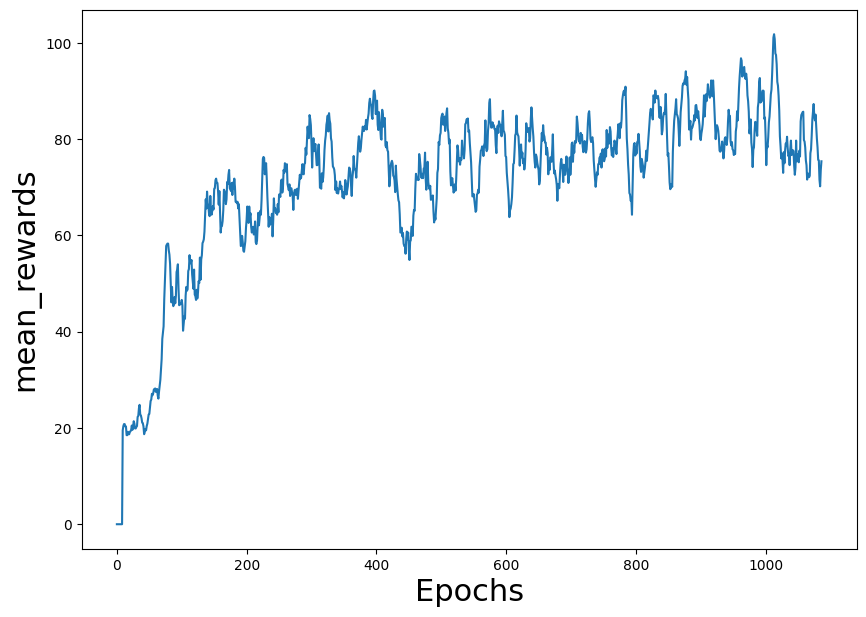

In [73]:
plt.figure(figsize=(10,7))
plt.plot(mean_rewards)
plt.xlabel("Epochs",fontsize=22)
plt.ylabel("mean_rewards",fontsize=22)

In [ ]:
torch.save(Agent, "packman_double_dueling_noisy_dqn_nn.pt")
torch.save(target_network, "packman_targetdouble_dueling_noisy_dqn_nn.pt")

In [48]:
game.close()

# Stock trading & Deep Q learning

In [62]:
import pandas as pd
import numpy as np
data = pd.read_csv("YNDX_150101_151231.csv")

In [63]:
data.head()

<DATE>  <TIME>  <OPEN>  <HIGH>   <LOW>  <CLOSE>  <VOL>
0  20150105  100100  1064.0  1064.0  1064.0   1064.0      0
1  20150105  100200  1064.0  1064.0  1064.0   1064.0      0
2  20150105  100300  1064.0  1064.0  1064.0   1064.0      0
3  20150105  100400  1064.0  1064.0  1064.0   1064.0      0
4  20150105  100500  1064.0  1064.0  1064.0   1064.0      0

In [23]:
columns={"<DATE>":"date" ,"<TIME>":"time" ,
         "<OPEN>":"open" ,"<HIGH>":"high" ,
         "<LOW>":"low" ,"<CLOSE>":"close" ,
         "<VOL>":"vol"}
data = data.rename(columns=columns)

In [24]:
del data["vol"] ,data["date"] ,data["time"]

In [25]:
data["remove"] = data.apply(lambda x: all([abs(i - x[0]) < 1e-8 for i in x]) ,axis=1)

In [26]:
data = data.query("remove == False").reset_index(drop=True)

In [27]:
del data["remove"]

In [31]:
data["high"] = (data["high"] - data["open"]) / data["open"]
data["low"]  = (data["low"] - data["open"]) / data["open"]
data["close"] = (data["close"] - data["open"]) / data["open"]

In [33]:
class YNDX_env:
    def __init__(self ,data ,obs_bars = 10 ,test = False ,commission_perc=0.1):
        self.data = data
        self.obs_bars = obs_bars
        self.have_position = False
        self.open_price = 0
        self.test = test
        self.commission_perc = commission_perc
        if test == False:
            self.curr_step =  np.random.choice(self.data.high.shape[0] - self.obs_bars*10) + self.obs_bars 
        else:
            self.curr_step = self.obs_bars 
            
        self.state = self.data[self.curr_step - self.obs_bars : self.curr_step]



    def step(self ,action):
        reward = 0
        done = False
        relative_close = self.state["close"][self.curr_step - 1]
        open = self.state["open"][self.curr_step - 1]
        close = open * ( 1 + relative_close)

        if action == "buy" and self.have_position == False:
            self.have_position = True
            self.open_price = close
            reward -= self.commission_perc 
            
        elif action == "close" and self.have_position == True:
            reward -= self.commission_perc
            if self.test == False:
                done = True
                
            reward += 100.0 * (close -  self.open_price) / self.open_price
            
            self.have_position = False
            self.open_price = 0.0      
            
        self.curr_step = self.curr_step + 1
        self.state = self.data[self.curr_step - self.obs_bars : self.curr_step] 
        
        if self.curr_step == len(self.data) - 1:
            done = True   
            
        state = np.zeros((5 ,self.obs_bars), dtype=np.float32)
        state[0] = self.state.high.to_list()
        state[1] = self.state.low.to_list()
        state[2] = self.state.close.to_list()
        state[3] = int(self.have_position) 
        if self.have_position:
            state[4] =  (close -  self.open_price) / self.open_price
        return state ,reward , done
        
        

In [34]:
actions = {0:"do_nothing" ,1:"buy" ,2:"close"}

In [35]:
 YNDX = YNDX_env(data,test=False,obs_bars=50)

In [36]:
state ,reward ,done = YNDX.step("do_nothing")

In [37]:
state.shape

(5, 50)

In [38]:
input_shape = state.shape

In [53]:
class dueling_Conv1D_Q_Net(torch.nn.Module):
    def __init__(self, input_depth_length , output_shape):
        super(dueling_Conv1D_Q_Net, self).__init__()
        self.conv1 = torch.nn.Conv1d(input_depth_length, 128, 5)
        self.conv2 = torch.nn.Conv1d(128, 128, 5)    
        self.state_value_linear1 =  torch.nn.Linear(5376 , 512)
        self.state_value_linear2 =  torch.nn.Linear(512, 1)
        self.advantage_linear1 =  torch.nn.Linear(5376 ,512)
        self.advantage_linear2 =  torch.nn.Linear(512 ,output_shape)
        self.activation = torch.nn.ReLU()
        self.flatten = torch.nn.Flatten()
    def forward(self ,x):
        x = self.conv1(x)
        x = self.activation(x)
        x = self.conv2(x)
        x = self.activation(x)
        x = self.flatten(x)
        x_state_val = self.state_value_linear1(x)
        x_state_val = self.activation(x_state_val)
        x_state_val = self.state_value_linear2(x_state_val)
        x_advantage = self.advantage_linear1(x)
        x_advantage = self.activation(x_advantage)
        x_advantage = self.advantage_linear2(x_advantage)     
        y = x_state_val + x_advantage - x_advantage.mean(dim=1).unsqueeze(1) 
        return y

In [54]:
def get_batch_for_nsteps_dqn(replay ,batch_size ,nsteps = 1 ,device = "cpu"):
    
    if nsteps < 1:
        nsteps = 1
        
    minibatch_idx = random.sample(range(len(replay)), batch_size)
    minibatch = [replay[idx] for idx in minibatch_idx]
    nsteps_next_state_batch = []
    nsteps_reward_batch = []
    nsteps_done_batch = []
    
    state1_batch = torch.cat([s1 for (s1 ,a ,r ,s2 ,d) in minibatch]).float().to(device)
    action1_batch = torch.tensor([a for (s1 ,a ,r ,s2 ,d) in minibatch]).long().to(device)
    
    for exp_idx in minibatch_idx:
        nsteps_next_state = []
        nsteps_reward = []
        
        for step in range(nsteps):  
            exp = replay[exp_idx + step]
            s1 ,a ,r ,s2 ,d = exp
            nsteps_reward.append(r)
            
            if d == True or step == nsteps - 1 or exp_idx + step == len(replay) - 1 :
                nsteps_next_state_batch.append(s2)
                nsteps_done_batch.append(d)
                break
                
        nsteps_reward_batch.append(nsteps_reward)
       
    nsteps_next_state_batch = torch.cat([s for s in nsteps_next_state_batch]).float().to(device)
    nsteps_done_batch = torch.tensor(nsteps_done_batch).long().to(device)

    return state1_batch ,action1_batch ,nsteps_next_state_batch ,nsteps_reward_batch  ,nsteps_done_batch 

In [55]:
def batch_target_for_nsteps_dqn(nsteps_reward_batch  ,gamma ,maxQ ,nsteps_done_batch ,device="cpu"): 
    Y_list = []
    for i , nsteps_reward in enumerate(nsteps_reward_batch):
        gamma_list = [gamma**i for i in range(len(nsteps_reward))]
        gamma_array = np.array(gamma_list)
        nsteps_reward = np.array(nsteps_reward)
        Y = torch.tensor(nsteps_reward * gamma_list).sum().to(device) + gamma**(len(nsteps_reward)) * maxQ[i] * (1 - nsteps_done_batch[i])
        Y_list.append(Y)
    return torch.tensor([Y for Y in Y_list]).float().to(device)

In [57]:
from collections import deque
import copy
memory_size = 100000
batch_size = 32
replay = deque(maxlen=memory_size)
gamma = 0.99
learning_rate =  0.0001
sync_freq = 1000
device="cuda"
output_shape = len(actions)

Agent_NN = dueling_Conv1D_Q_Net(input_shape[0] ,output_shape).to(device)
target_NN = copy.deepcopy(Agent_NN)
target_NN.load_state_dict(Agent_NN.state_dict()) 

optimizer = torch.optim.RMSprop(Agent_NN.parameters(), lr=learning_rate)
loss_fn = torch.nn.MSELoss()
all_rewards_list = []
mean_rewards = []
Q_losses = []
epsilon = 1.
k = 0
while(k < 2600000):
    game = YNDX_env(data ,commission_perc=0.1 ,obs_bars=50)
    state1 ,_ ,_  = game.step("do_nothing")
    state1 = np.array(state1)
    state1 = preprocess_state(state1 ,(1,*input_shape) ,add_noise = False)
    state1 = torch.from_numpy(state1).float()
    status = 1 
    episode_rewards = []
    while(status == 1): 
        k = k + 1
        with torch.no_grad():
            qval = Agent_NN(state1.to(device))
            qval_ = qval.data.cpu().numpy()
        action = get_action(qval_ , 3, epsilon)
        action_name = actions[action]
        state2 ,reward ,done = game.step(action_name)
        state2 = np.array(state2)
        state2 = preprocess_state(state2 ,(1,*input_shape) ,add_noise = False)
        state2 = torch.from_numpy(state2).float()
        exp =  (state1, action, reward, state2, done)
        episode_rewards.append(reward)
        replay.append(exp) 


        if len(replay) >= 10000: 
            state1_batch ,action1_batch ,nsteps_next_state_batch ,nsteps_reward_batch ,nsteps_done_batch = get_batch_for_nsteps_dqn(replay =replay,
                                                                                                                                    batch_size = batch_size,
                                                                                                                                    nsteps=2 ,device=device)

            
            state_batch = torch.cat([state1_batch ,nsteps_next_state_batch],dim=0)
            Q_1_and_n = Agent_NN(state_batch) 
            Q1 = Q_1_and_n[:batch_size]
            
            with torch.no_grad():
                Q_next_state = Q_1_and_n[batch_size:]
                selected_nodes_for_target_network =  Q_next_state.max(1)[1]
                Q_next_state = target_NN(nsteps_next_state_batch)
                
            best_Q_next_state = Q_next_state.gather(dim=1,index=selected_nodes_for_target_network.unsqueeze(dim=1)).squeeze()
            Y = batch_target_for_nsteps_dqn(nsteps_reward_batch  ,gamma ,best_Q_next_state ,nsteps_done_batch ,device=device)
            X = Q1.gather(dim=1,index=action1_batch.unsqueeze(dim=1)).squeeze()
            loss = loss_fn(X, Y) 
            #loss = losses.mean()
            print("current step" ,k)
            print("mean_reward:" ,mean_rewards[-1])
            print(loss.item())
            clear_output(wait=True)
            Q_losses.append(loss.item())
            update(loss ,optimizer)
     

        state1 = state2
        if k % sync_freq == 0: 
            target_NN.load_state_dict(Agent_NN.state_dict())
            

        if done == True: 
            mean_rewards.append(np.array(episode_rewards).sum())
            status = 0

    if k < 1000000: 
        epsilon = 1 - 0.9 * (k / 1000000)
    else:
        epsilon = 0.1
        

current step 2600024
mean_reward: -1.2948905109489053
0.018964139744639397


In [69]:
test = pd.read_csv("YNDX_160101_161231.csv")

In [70]:
columns={"<DATE>":"date" ,"<TIME>":"time" ,
         "<OPEN>":"open" ,"<HIGH>":"high" ,
         "<LOW>":"low" ,"<CLOSE>":"close" ,
         "<VOL>":"vol"}
test = test.rename(columns=columns)

In [71]:
del test["vol"] ,test["date"] ,test["time"]

In [72]:
test["remove"] = test.apply(lambda x: all([abs(i - x[0]) < 1e-8 for i in x]) ,axis=1)

In [73]:
test = test.query("remove == False").reset_index(drop=True)

In [74]:
del test["remove"]

In [75]:
test["high"] = (test["high"] - test["open"]) / test["open"]
test["low"]  = (test["low"] - test["open"]) / test["open"]
test["close"] = (test["close"] - test["open"]) / test["open"]

In [ ]:
game = YNDX_env(test ,commission_perc=0.1 ,obs_bars=50 ,test=True)
state1 ,_ ,_  = game.step("do_nothing")
state1 = np.array(state1)
state1 = preprocess_state(state1 ,(1,*input_shape) ,add_noise = False)
state1 = torch.from_numpy(state1).float()
status = 1 
rewards = []
i = 0
while(status == 1): 
        with torch.no_grad():
            qval = Agent_NN(state1.to(device))
            qval_ = qval.data.cpu().numpy()
        action = np.argmax(qval_ ,1)[0]
        action_name = actions[action]
        print(action_name)
        i = i + 1
        print(i)
        state2 ,reward ,done  = game.step(action_name)
        rewards.append(reward)
        state2 = np.array(state2)
        state2 = preprocess_state(state2 ,(1,*input_shape) ,add_noise = False)
        state2 = torch.from_numpy(state2).float()        
        state1 = state2
        clear_output(wait=True)
        if done == True: 
            status = 0          

do_nothing
17974


Text(0, 0.5, 'rewards')

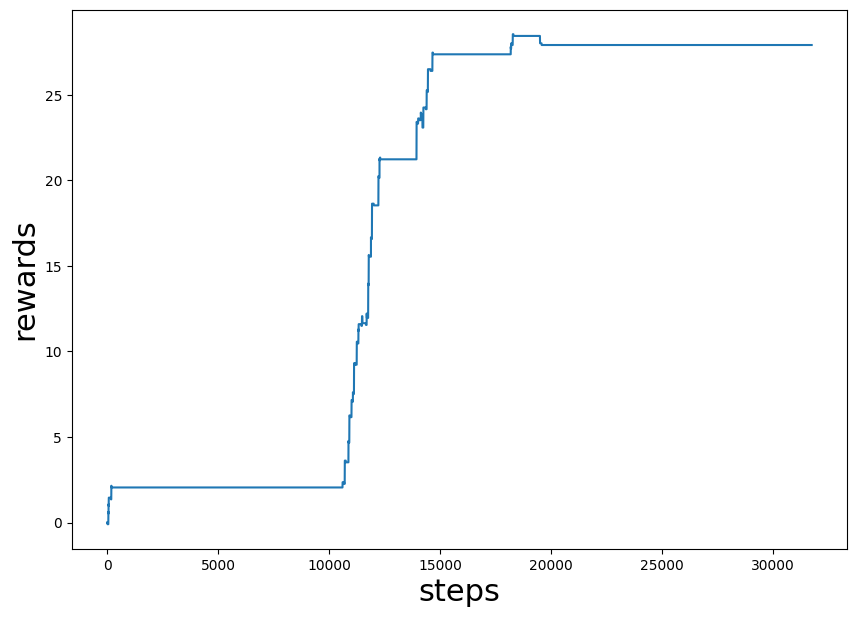

In [79]:
plt.figure(figsize=(10,7))
plt.plot(np.cumsum(rewards))
plt.xlabel("steps",fontsize=22)
plt.ylabel("rewards",fontsize=22)